In [1]:
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# ----- Hyperparameters and Paths -----
data_dir = '/home/idrone2/Desktop/Kaggle_datasets/Tea_leaf_dataset'  # folder with subfolders per class (5 classes)
num_classes = 5
batch_size = 16
num_epochs = 20
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Data Transforms -----
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ----- Load Full Dataset and Perform 80/20 Split -----
full_dataset = datasets.ImageFolder(data_dir)  # no transform initially
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Set the transforms for each subset
train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = val_test_transforms

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ----- Compute Overall Image Intensity Distribution -----
def compute_rgb_intensity_histogram(dataset, bins=50):
    import numpy as np
    # Create histogram accumulators for each channel (R, G, B)
    hist_counts = [np.zeros(bins) for _ in range(3)]
    # Define bin edges for the histogram (assuming pixel values in [0, 1])
    bin_edges = np.linspace(0, 1, bins+1)
    
    for img, _ in tqdm(dataset, desc="Computing intensity histogram"):
        # img is a tensor with shape [C, H, W]
        for c in range(3):
            # Convert tensor to numpy array and flatten
            channel_data = img[c].cpu().numpy().flatten()
            counts, _ = np.histogram(channel_data, bins=bin_edges)
            hist_counts[c] += counts
    return hist_counts, bin_edges

# Compute histogram counts instead of accumulating all pixel values
hist_counts, bin_edges = compute_rgb_intensity_histogram(train_dataset)

# Plotting the RGB intensity histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
colors = ['red', 'green', 'blue']
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
for c in range(3):
    plt.plot(bin_centers, hist_counts[c], color=colors[c], label=f'{colors[c].upper()} channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Overall RGB Intensity Distribution (Train Dataset)')
plt.legend()
plt.savefig('rgb_intensity_histogram.png')
plt.close()


# ----- Simplified ViG Model Definition -----
class ViGBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super(ViGBlock, self).__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.GELU(),
            nn.Linear(dim*4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
    
    def forward(self, x):
        # x shape: [B, N, D] where N is number of patches
        x = x.transpose(0, 1)  # -> [N, B, D] required by nn.MultiheadAttention
        attn_out, _ = self.attn(x, x, x)
        x = x + attn_out
        x = self.norm1(x)
        fc_out = self.fc(x)
        x = x + fc_out
        x = self.norm2(x)
        return x.transpose(0, 1)  # back to [B, N, D]

class ViG(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=5, embed_dim=128, depth=4, num_heads=4):
        super(ViG, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Patch embedding: Conv layer to create patches
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        # ViG blocks
        self.blocks = nn.ModuleList([
            ViGBlock(dim=embed_dim, num_heads=num_heads) for _ in range(depth)
        ])
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        # x: [B, 3, 224, 224]
        x = self.patch_embed(x)  # [B, embed_dim, H', W']
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        
        for block in self.blocks:
            x = block(x)
        
        # Global average pooling over patches
        x = x.transpose(1, 2)  # [B, embed_dim, num_patches]
        x = self.global_pool(x).squeeze(-1)  # [B, embed_dim]
        x = self.fc(x)
        return x

model = ViG(num_classes=num_classes).to(device)

# ----- Save Model Architecture Parameters to CSV -----
def export_model_params(model, csv_filename='model_parameters.csv'):
    params = []
    for name, param in model.named_parameters():
        params.append({
            'layer': name,
            'shape': list(param.shape),
            'num_params': param.numel()
        })
    keys = ['layer', 'shape', 'num_params']
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=keys)
        writer.writeheader()
        for row in params:
            writer.writerow(row)

export_model_params(model)

# ----- Training and Evaluation Functions -----
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += images.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += images.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# ----- Training Loop -----
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_model(model, test_loader, criterion)
    
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save training logs to CSV
with open('training_logs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])
    for i in range(num_epochs):
        writer.writerow([i+1, train_losses[i], train_accs[i], val_losses[i], val_accs[i]])

# ----- Plot Training Curves -----
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.close()

# ----- Evaluate on Test Set -----
test_loss, test_acc = eval_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Optionally, save final model weights
torch.save(model.state_dict(), 'vig_model_final.pth')


Computing intensity histogram: 100%|██████████| 3168/3168 [00:25<00:00, 122.84it/s]


Epoch 1/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 33.57it/s]


Train Loss: 0.7456, Train Acc: 0.7390
Val Loss: 1.0069, Val Acc: 0.6515
Epoch 2/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 39.16it/s]


Train Loss: 0.5352, Train Acc: 0.8210
Val Loss: 0.4191, Val Acc: 0.8712
Epoch 3/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 39.11it/s]


Train Loss: 0.4401, Train Acc: 0.8438
Val Loss: 0.4592, Val Acc: 0.8510
Epoch 4/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 39.09it/s]


Train Loss: 0.5724, Train Acc: 0.8059
Val Loss: 1.1187, Val Acc: 0.7513
Epoch 5/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 34.06it/s]


Train Loss: 0.9363, Train Acc: 0.6471
Val Loss: 1.6386, Val Acc: 0.5290
Epoch 6/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 36.64it/s]


Train Loss: 1.0651, Train Acc: 0.6278
Val Loss: 1.2166, Val Acc: 0.5657
Epoch 7/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 36.51it/s]


Train Loss: 1.1573, Train Acc: 0.5751
Val Loss: 1.1781, Val Acc: 0.5657
Epoch 8/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 34.92it/s]


Train Loss: 1.1527, Train Acc: 0.5751
Val Loss: 1.1608, Val Acc: 0.5657
Epoch 9/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 36.80it/s]


Train Loss: 1.1528, Train Acc: 0.5751
Val Loss: 1.1855, Val Acc: 0.5657
Epoch 10/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 37.02it/s]


Train Loss: 1.1530, Train Acc: 0.5751
Val Loss: 1.1673, Val Acc: 0.5657
Epoch 11/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 31.60it/s]


Train Loss: 1.1519, Train Acc: 0.5751
Val Loss: 1.1684, Val Acc: 0.5657
Epoch 12/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 37.19it/s]


Train Loss: 1.1540, Train Acc: 0.5751
Val Loss: 1.1633, Val Acc: 0.5657
Epoch 13/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 34.63it/s]


Train Loss: 1.1538, Train Acc: 0.5751
Val Loss: 1.1631, Val Acc: 0.5657
Epoch 14/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 37.32it/s]


Train Loss: 1.1513, Train Acc: 0.5751
Val Loss: 1.1626, Val Acc: 0.5657
Epoch 15/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 36.35it/s]


Train Loss: 1.1512, Train Acc: 0.5751
Val Loss: 1.1603, Val Acc: 0.5657
Epoch 16/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 32.57it/s]


Train Loss: 1.1506, Train Acc: 0.5751
Val Loss: 1.1683, Val Acc: 0.5657
Epoch 17/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 34.77it/s]


Train Loss: 1.1505, Train Acc: 0.5751
Val Loss: 1.1652, Val Acc: 0.5657
Epoch 18/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 37.39it/s]


Train Loss: 1.1504, Train Acc: 0.5751
Val Loss: 1.1624, Val Acc: 0.5657
Epoch 19/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 34.70it/s]


Train Loss: 1.1507, Train Acc: 0.5751
Val Loss: 1.1620, Val Acc: 0.5657
Epoch 20/20


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 37.02it/s]


Train Loss: 1.1504, Train Acc: 0.5751
Val Loss: 1.1650, Val Acc: 0.5657


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 33.90it/s]

Test Loss: 1.1650, Test Accuracy: 0.5657


Computing intensity histogram:   0%|          | 0/3168 [00:00<?, ?it/s]

Computing intensity histogram: 100%|██████████| 3168/3168 [00:24<00:00, 131.76it/s]


Epoch 1/10


Train Loss: 0.7211, Train Acc: 0.7522
Val Loss: 0.4080, Val Acc: 0.8838
Epoch 2/10


Train Loss: 0.2929, Train Acc: 0.9208
Val Loss: 0.1990, Val Acc: 0.9495
Epoch 3/10


Train Loss: 0.1594, Train Acc: 0.9476
Val Loss: 0.2019, Val Acc: 0.9255
Epoch 4/10


Train Loss: 0.1075, Train Acc: 0.9659
Val Loss: 0.0780, Val Acc: 0.9760
Epoch 5/10


Train Loss: 0.0802, Train Acc: 0.9754
Val Loss: 0.0661, Val Acc: 0.9811
Epoch 6/10


Train Loss: 0.0911, Train Acc: 0.9716
Val Loss: 0.0534, Val Acc: 0.9861
Epoch 7/10


Train Loss: 0.0495, Train Acc: 0.9842
Val Loss: 0.0467, Val Acc: 0.9886
Epoch 8/10


Train Loss: 0.0392, Train Acc: 0.9880
Val Loss: 0.0296, Val Acc: 0.9937
Epoch 9/10


Train Loss: 0.0310, Train Acc: 0.9921
Val Loss: 0.0292, Val Acc: 0.9924
Epoch 10/10


Train Loss: 0.0460, Train Acc: 0.9867
Val Loss: 0.0853, Val Acc: 0.9760


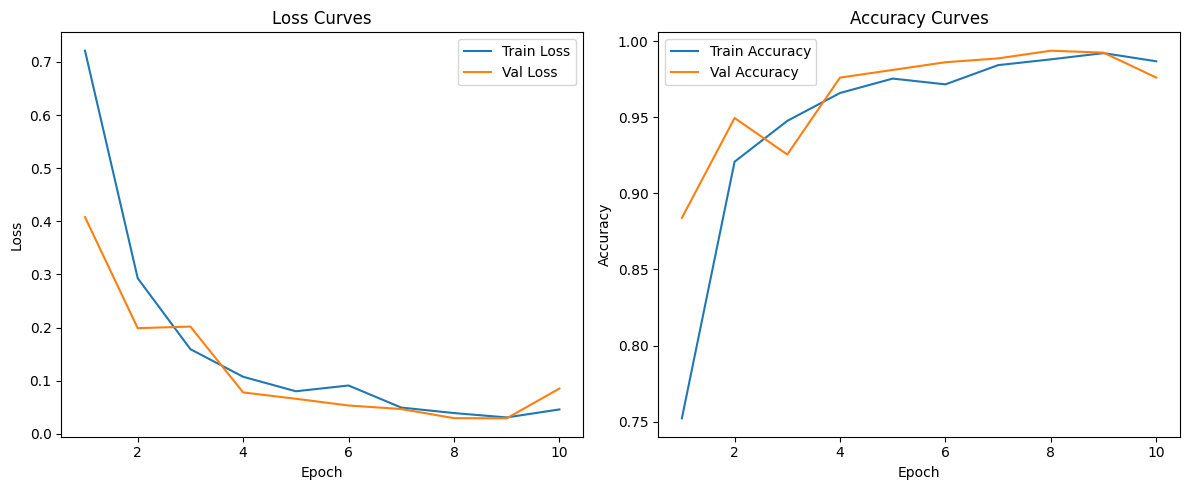

Test Loss: 0.0853, Test Accuracy: 0.9760


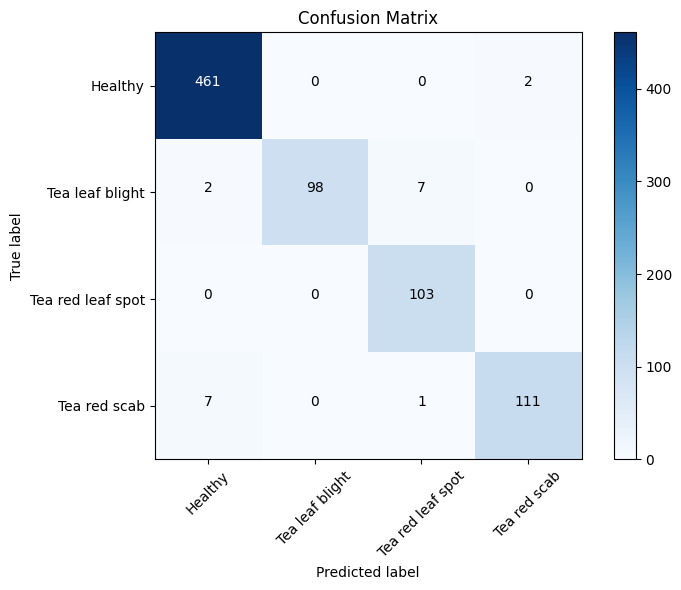

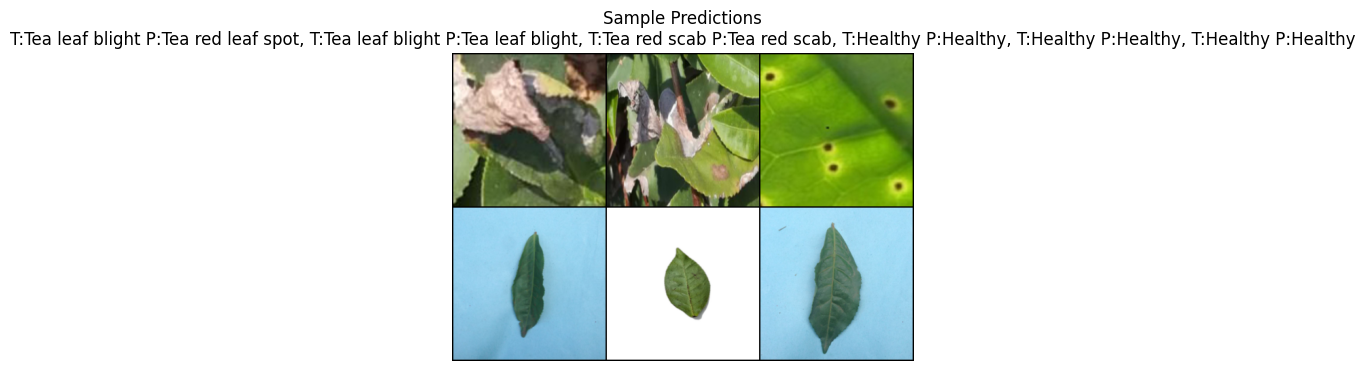

In [5]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import itertools

# -------------------- Hyperparameters and Paths --------------------
data_dir = '/home/idrone2/Desktop/Kaggle_datasets/Tea_leaf_dataset'  # Folder with subfolders per class (5 classes)
num_classes = 5
batch_size = 16
num_epochs = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else"cpu")

# -------------------- Data Transforms --------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# -------------------- Load Full Dataset and Perform 80/20 Split --------------------
full_dataset = datasets.ImageFolder(data_dir)  # No transform initially; transforms set later
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Set the transforms for each subset
train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = val_test_transforms

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# -------------------- Compute Overall Image Intensity Distribution (Efficient) --------------------
def compute_rgb_intensity_histogram(dataset, bins=50):
    # Create histogram accumulators for each channel (R, G, B)
    hist_counts = [np.zeros(bins) for _ in range(3)]
    # Define bin edges (assuming pixel values in [0, 1])
    bin_edges = np.linspace(0, 1, bins+1)
    
    for img, _ in tqdm(dataset, desc="Computing intensity histogram"):
        # img is a tensor with shape [C, H, W]
        for c in range(3):
            channel_data = img[c].cpu().numpy().flatten()
            counts, _ = np.histogram(channel_data, bins=bin_edges)
            hist_counts[c] += counts
    return hist_counts, bin_edges

hist_counts, bin_edges = compute_rgb_intensity_histogram(train_dataset)

# Plot RGB intensity histogram
plt.figure(figsize=(10, 4))
colors = ['red', 'green', 'blue']
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
for c in range(3):
    plt.plot(bin_centers, hist_counts[c], color=colors[c], label=f'{colors[c].upper()} channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Overall RGB Intensity Distribution (Train Dataset)')
plt.legend()
plt.savefig('rgb_intensity_histogram.png')
plt.close()

# -------------------- ViG-Inspired Model Definition --------------------
class ViGBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super(ViGBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
    
    def forward(self, x):
        # x: [B, N, D] where N = number of patches
        x = x.transpose(0, 1)  # to [N, B, D] for multihead attention
        attn_out, _ = self.attn(x, x, x)
        x = x + attn_out
        x = self.norm1(x)
        fc_out = self.fc(x)
        x = x + fc_out
        x = self.norm2(x)
        return x.transpose(0, 1)  # back to [B, N, D]

class ViG(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=5, embed_dim=128, depth=4, num_heads=4):
        super(ViG, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Patch embedding (using a convolution)
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        # Stack of ViG blocks
        self.blocks = nn.ModuleList([
            ViGBlock(dim=embed_dim, num_heads=num_heads) for _ in range(depth)
        ])
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        # x: [B, 3, 224, 224]
        x = self.patch_embed(x)  # [B, embed_dim, H', W']
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        
        for block in self.blocks:
            x = block(x)
        
        # Global average pooling over patches
        x = x.transpose(1, 2)  # [B, embed_dim, num_patches]
        x = self.global_pool(x).squeeze(-1)  # [B, embed_dim]
        x = self.fc(x)
        return x

model = ViG(num_classes=num_classes).to(device)

# -------------------- Export Model Architecture Parameters --------------------
def export_model_params(model, csv_filename='model_parameters.csv'):
    params = []
    for name, param in model.named_parameters():
        params.append({
            'layer': name,
            'shape': list(param.shape),
            'num_params': param.numel()
        })
    keys = ['layer', 'shape', 'num_params']
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=keys)
        writer.writeheader()
        for row in params:
            writer.writerow(row)

export_model_params(model)

# -------------------- Training and Evaluation Functions --------------------
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------- Training Loop --------------------
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = eval_model(model, test_loader, criterion)
    
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save training logs to CSV
with open('training_logs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])
    for i in range(num_epochs):
        writer.writerow([i+1, train_losses[i], train_accs[i], val_losses[i], val_accs[i]])

# -------------------- Plot Training Curves --------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()  # Display training curves
plt.close()

# -------------------- Evaluate on Test Set and Compute Confusion Matrix --------------------
test_loss, test_acc, all_preds, all_labels = eval_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Confusion Matrix Plot
cm = confusion_matrix(all_labels, all_preds)
classes = full_dataset.classes

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
plt.close()

# -------------------- Display Sample Predictions --------------------
def display_sample_predictions(model, loader, num_samples=6):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    # Create a grid of images
    img_grid = utils.make_grid(images[:num_samples].cpu(), nrow=3, normalize=True)
    np_img = img_grid.numpy().transpose((1, 2, 0))
    
    # Plot the grid with predicted and true labels
    plt.figure(figsize=(10, 4))
    plt.imshow(np_img)
    plt.title("Sample Predictions\n" + ", ".join([f"T:{classes[labels[i]]} P:{classes[preds[i]]}" for i in range(num_samples)]))
    plt.axis('off')
    plt.savefig('sample_predictions.png')
    plt.show()

display_sample_predictions(model, test_loader)

# -------------------- Save Final Model Weights --------------------
torch.save(model.state_dict(), 'vig_model_final.pth')


Computing intensity histogram: 100%|██████████| 3168/3168 [00:25<00:00, 124.97it/s]


Epoch 1/10


Train Loss: 0.6688, Train Acc: 0.7696
Val Loss: 0.4003, Val Acc: 0.8485
Epoch 2/10


Train Loss: 0.2665, Train Acc: 0.9208
Val Loss: 0.2139, Val Acc: 0.9369
Epoch 3/10


Train Loss: 0.1481, Train Acc: 0.9523
Val Loss: 0.1281, Val Acc: 0.9609
Epoch 4/10


Train Loss: 0.1102, Train Acc: 0.9665
Val Loss: 0.1499, Val Acc: 0.9596
Epoch 5/10


Train Loss: 0.0779, Train Acc: 0.9751
Val Loss: 0.0618, Val Acc: 0.9811
Epoch 6/10


Train Loss: 0.0753, Train Acc: 0.9776
Val Loss: 0.0909, Val Acc: 0.9735
Epoch 7/10


Train Loss: 0.0510, Train Acc: 0.9826
Val Loss: 0.0580, Val Acc: 0.9722
Epoch 8/10


Train Loss: 0.0406, Train Acc: 0.9883
Val Loss: 0.0497, Val Acc: 0.9760
Epoch 9/10


Train Loss: 0.0529, Train Acc: 0.9830
Val Loss: 0.0623, Val Acc: 0.9747
Epoch 10/10


Train Loss: 0.0425, Train Acc: 0.9874
Val Loss: 0.0532, Val Acc: 0.9836


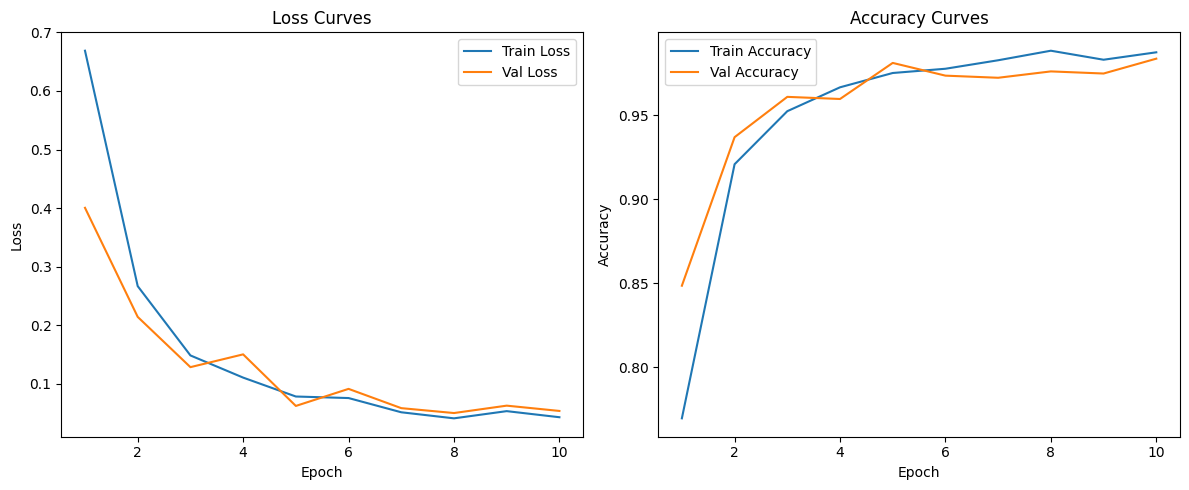

Test Loss: 0.0532, Test Accuracy: 0.9836


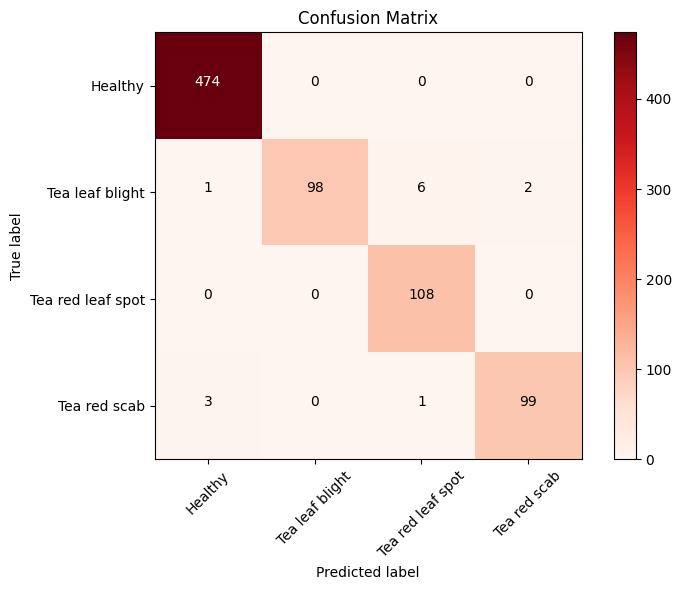

/home/idrone2/.local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/idrone2/.local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Classification Report:
                   precision    recall  f1-score     support
Healthy             0.991632  1.000000  0.995798  474.000000
Tea leaf blight     1.000000  0.915888  0.956098  107.000000
Tea red leaf spot   0.939130  1.000000  0.968610  108.000000
Tea red scab        0.980198  0.961165  0.970588  103.000000
accuracy            0.983586  0.983586  0.983586    0.983586
macro avg           0.977740  0.969263  0.972773  792.000000
weighted avg        0.984116  0.983586  0.983449  792.000000
Specificity per class:
Healthy: 0.9874
Tea leaf blight: 1.0000
Tea red leaf spot: 0.9898
Tea red scab: 0.9971
Mean Average Precision (mAP): 0.7990


IndexError: list index out of range

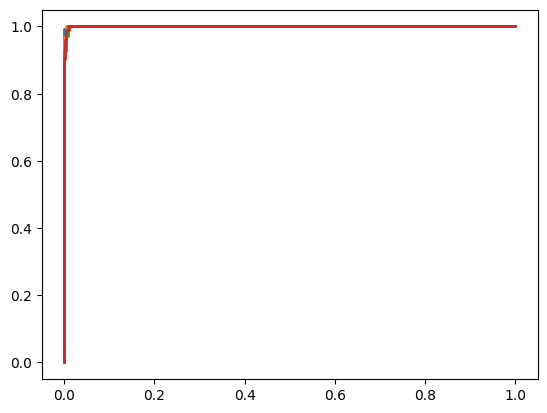

In [6]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import itertools
import pandas as pd

# Optional: for network architecture visualization (requires torchviz)
try:
    from torchviz import make_dot
    TORCHVIZ_AVAILABLE = True
except ImportError:
    TORCHVIZ_AVAILABLE = False

# -------------------- Hyperparameters and Paths --------------------
data_dir = '/home/idrone2/Desktop/Kaggle_datasets/Tea_leaf_dataset'  # Folder with subfolders per class (5 classes)
num_classes = 5
batch_size = 16
num_epochs = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- Data Transforms --------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# -------------------- Load Full Dataset and Perform 80/20 Split --------------------
full_dataset = datasets.ImageFolder(data_dir)  # No transform initially; transforms set later
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Set transforms for each subset
train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = val_test_transforms

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# -------------------- Compute Overall RGB Intensity Distribution --------------------
def compute_rgb_intensity_histogram(dataset, bins=50):
    hist_counts = [np.zeros(bins) for _ in range(3)]
    bin_edges = np.linspace(0, 1, bins+1)
    for img, _ in tqdm(dataset, desc="Computing intensity histogram"):
        for c in range(3):
            channel_data = img[c].cpu().numpy().flatten()
            counts, _ = np.histogram(channel_data, bins=bin_edges)
            hist_counts[c] += counts
    return hist_counts, bin_edges

hist_counts, bin_edges = compute_rgb_intensity_histogram(train_dataset)

plt.figure(figsize=(10, 4))
colors = ['red', 'green', 'blue']
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
for c in range(3):
    plt.plot(bin_centers, hist_counts[c], color=colors[c], label=f'{colors[c].upper()} channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Overall RGB Intensity Distribution (Train Dataset)')
plt.legend()
plt.savefig('rgb_intensity_histogram.png')
plt.close()

# -------------------- ViG-Inspired Model Definition --------------------
class ViGBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super(ViGBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
    
    def forward(self, x):
        # x: [B, N, D] where N = number of patches
        x = x.transpose(0, 1)  # [N, B, D] for attention
        attn_out, _ = self.attn(x, x, x)
        x = x + attn_out
        x = self.norm1(x)
        fc_out = self.fc(x)
        x = x + fc_out
        x = self.norm2(x)
        return x.transpose(0, 1)  # back to [B, N, D]

class ViG(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=5, embed_dim=128, depth=4, num_heads=4):
        super(ViG, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.blocks = nn.ModuleList([ViGBlock(dim=embed_dim, num_heads=num_heads) for _ in range(depth)])
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        x = self.patch_embed(x)  # [B, embed_dim, H', W']
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        for block in self.blocks:
            x = block(x)
        x = x.transpose(1, 2)  # [B, embed_dim, num_patches]
        x = self.global_pool(x).squeeze(-1)  # [B, embed_dim]
        x = self.fc(x)
        return x

model = ViG(num_classes=num_classes).to(device)

# -------------------- Export Model Architecture Parameters --------------------
def export_model_params(model, csv_filename='model_parameters.csv'):
    params = []
    for name, param in model.named_parameters():
        params.append({
            'layer': name,
            'shape': list(param.shape),
            'num_params': param.numel()
        })
    keys = ['layer', 'shape', 'num_params']
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=keys)
        writer.writeheader()
        for row in params:
            writer.writerow(row)

export_model_params(model)

# -------------------- Training and Evaluation Functions --------------------
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
    return running_loss / total, correct / total

# Modified evaluation to also return probability scores (softmax)
def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    all_probs = np.concatenate(all_probs, axis=0)
    return running_loss / total, correct / total, all_preds, all_labels, all_probs

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------- Training Loop --------------------
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = eval_model(model, test_loader, criterion)
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save training logs to CSV
with open('training_logs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])
    for i in range(num_epochs):
        writer.writerow([i+1, train_losses[i], train_accs[i], val_losses[i], val_accs[i]])

# -------------------- Plot Training Curves --------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()
plt.close()

# -------------------- Evaluate on Test Set & Collect Probabilities --------------------
test_loss, test_acc, all_preds, all_labels, all_probs = eval_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# -------------------- Confusion Matrix (Red Color) --------------------
cm = confusion_matrix(all_labels, all_preds)
classes = full_dataset.classes
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
plt.close()

# -------------------- Classification Report, mAP & Specificity --------------------
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("Classification Report:")
print(df_report)
df_report.to_csv('classification_report.csv', index=True)

# Compute per-class specificity from the confusion matrix
specificity = {}
for i in range(len(classes)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FN - FP
    specificity[classes[i]] = TN / (TN + FP) if (TN + FP) > 0 else 0.0
print("Specificity per class:")
for cls, spec in specificity.items():
    print(f"{cls}: {spec:.4f}")

# Compute mAP using average_precision_score for each class (one-vs-rest)
binarized_labels = label_binarize(all_labels, classes=range(num_classes))
average_precision = {}
for i in range(num_classes):
    average_precision[i] = average_precision_score(binarized_labels[:, i], all_probs[:, i])
mAP = np.mean(list(average_precision.values()))
print(f"Mean Average Precision (mAP): {mAP:.4f}")

# -------------------- ROC Curves --------------------
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve {classes[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig('roc_curves.png')
plt.show()
plt.close()

# -------------------- Precision-Recall (PR) Curves --------------------
plt.figure()
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(binarized_labels[:, i], all_probs[:, i])
    ap = average_precision[i]
    plt.plot(recall, precision, lw=2, label=f'PR curve {classes[i]} (AP = {ap:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.savefig('pr_curves.png')
plt.show()
plt.close()

# -------------------- Model Architecture Parameters Graph --------------------
# Read the CSV and plot a bar chart of parameter counts per layer
df_params = pd.read_csv('model_parameters.csv')
plt.figure(figsize=(12, 6))
plt.bar(df_params['layer'], df_params['num_params'])
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Layer')
plt.ylabel('Number of Parameters')
plt.title('Model Architecture Parameter Count')
plt.tight_layout()
plt.savefig('model_parameters_bar.png')
plt.show()
plt.close()

# -------------------- Graphical Neural Network (Model Architecture Visualization) --------------------
if TORCHVIZ_AVAILABLE:
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    dot = make_dot(model(sample_input), params=dict(model.named_parameters()))
    dot.format = 'png'
    dot.render("model_architecture_graph")
    print("Model architecture graph saved as 'model_architecture_graph.png'.")
else:
    print("torchviz not available. Install it via 'pip install torchviz' to visualize the model architecture.")

# -------------------- Display Sample Predictions --------------------
def display_sample_predictions(model, loader, num_samples=6):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    img_grid = utils.make_grid(images[:num_samples].cpu(), nrow=3, normalize=True)
    np_img = img_grid.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 4))
    plt.imshow(np_img)
    plt.title("Sample Predictions\n" + ", ".join([f"T:{classes[labels[i]]} P:{classes[preds[i]]}" for i in range(num_samples)]))
    plt.axis('off')
    plt.savefig('sample_predictions.png')
    plt.show()

display_sample_predictions(model, test_loader)

# -------------------- Save Final Model Weights --------------------
torch.save(model.state_dict(), 'vig_model_final.pth')


# updated 

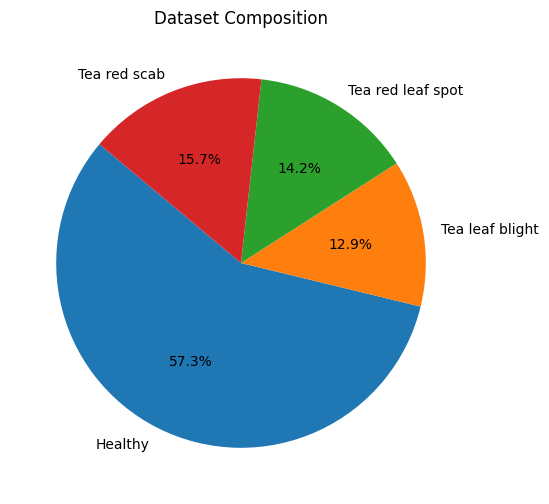

Dataset Composition (Absolute Counts):
Healthy: 2270
Tea leaf blight: 509
Tea red leaf spot: 561
Tea red scab: 620


Computing intensity histogram: 100%|██████████| 3009/3009 [00:21<00:00, 142.99it/s]


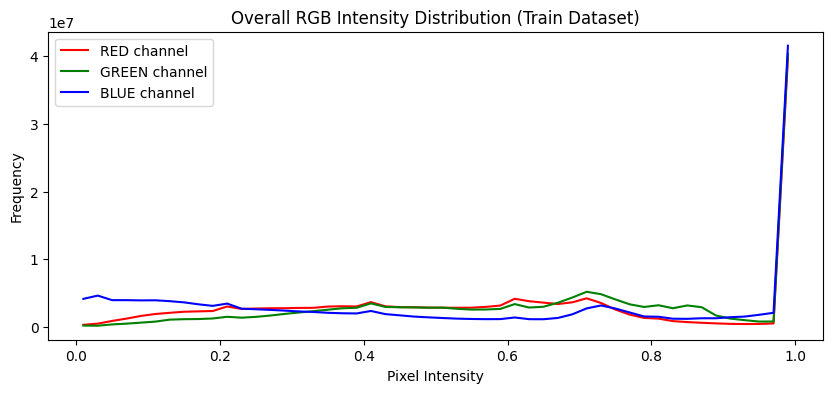


Epoch 1/10


Train Loss: 0.8087, Train Acc: 0.7165
Val Loss: 0.4701, Val Acc: 0.8749

Epoch 2/10


Train Loss: 0.3489, Train Acc: 0.9026
Val Loss: 0.2347, Val Acc: 0.9390

Epoch 3/10


Train Loss: 0.1950, Train Acc: 0.9462
Val Loss: 0.1988, Val Acc: 0.9348

Epoch 4/10


Train Loss: 0.1405, Train Acc: 0.9598
Val Loss: 0.1241, Val Acc: 0.9653

Epoch 5/10


Train Loss: 0.0989, Train Acc: 0.9711
Val Loss: 0.0795, Val Acc: 0.9769

Epoch 6/10


Train Loss: 0.0634, Train Acc: 0.9821
Val Loss: 0.0572, Val Acc: 0.9842

Epoch 7/10


Train Loss: 0.0553, Train Acc: 0.9811
Val Loss: 0.2058, Val Acc: 0.9159

Epoch 8/10


Train Loss: 0.0722, Train Acc: 0.9787
Val Loss: 0.0389, Val Acc: 0.9832

Epoch 9/10


Train Loss: 0.0493, Train Acc: 0.9854
Val Loss: 0.0247, Val Acc: 0.9895

Epoch 10/10


Train Loss: 0.0419, Train Acc: 0.9894
Val Loss: 0.0206, Val Acc: 0.9926


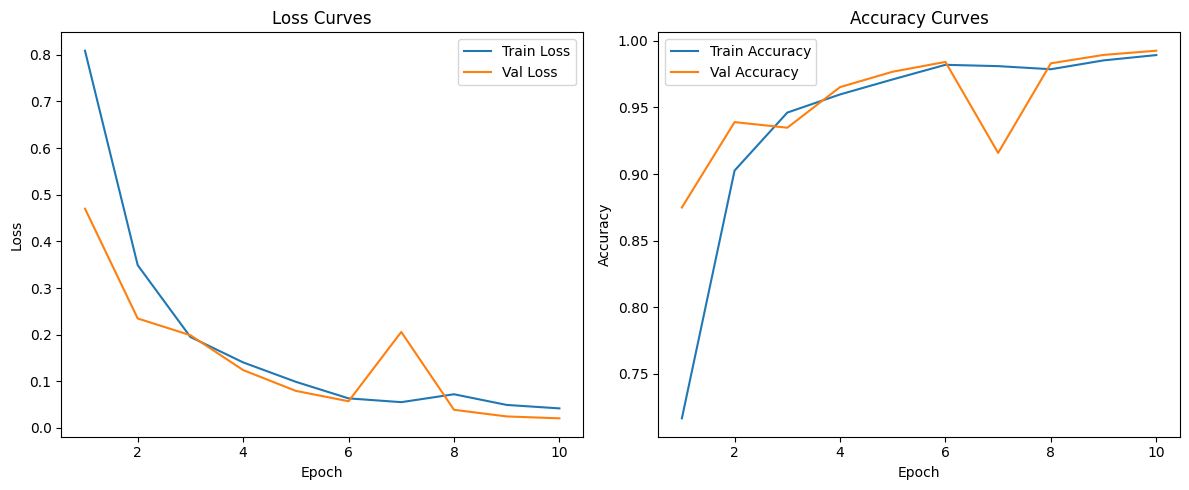


Final Test Loss: 0.0206, Test Accuracy: 0.9926


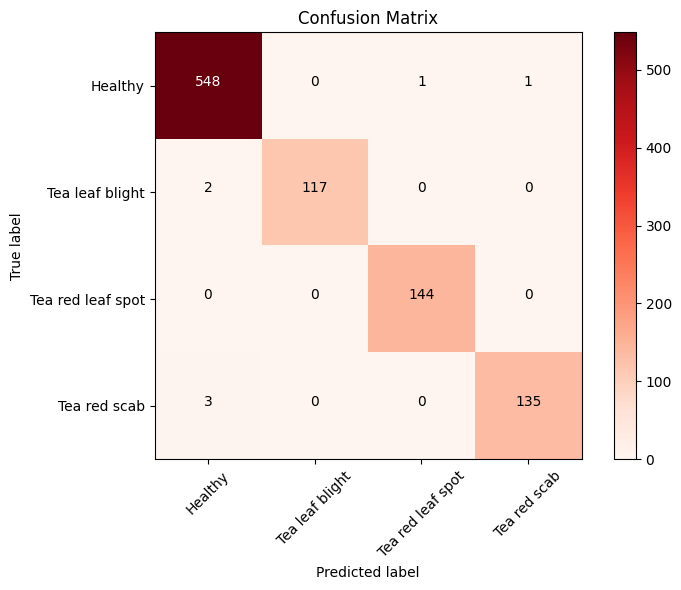

Classification Report:
                   precision    recall  f1-score     support
Healthy             0.990958  0.996364  0.993654  550.000000
Tea leaf blight     1.000000  0.983193  0.991525  119.000000
Tea red leaf spot   0.993103  1.000000  0.996540  144.000000
Tea red scab        0.992647  0.978261  0.985401  138.000000
accuracy            0.992639  0.992639  0.992639    0.992639
macro avg           0.994177  0.989454  0.991780  951.000000
weighted avg        0.992660  0.992639  0.992627  951.000000
Specificity per class:
Healthy: 0.9875
Tea leaf blight: 1.0000
Tea red leaf spot: 0.9988
Tea red scab: 0.9988
Mean Average Precision (mAP): 0.9998


IndexError: list index out of range

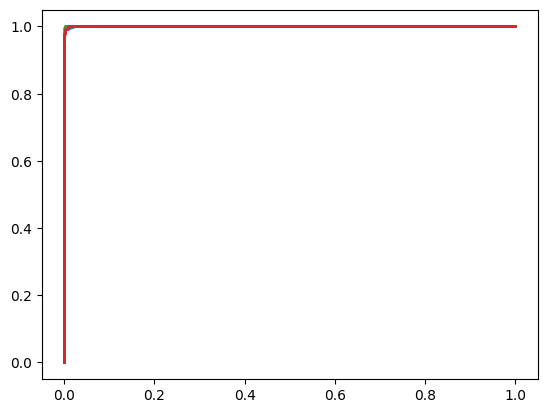

In [9]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
import itertools
import pandas as pd

# Optional: for network architecture visualization (requires torchviz)
try:
    from torchviz import make_dot
    TORCHVIZ_AVAILABLE = True
except ImportError:
    TORCHVIZ_AVAILABLE = False

# -------------------- Hyperparameters and Paths --------------------
data_dir = '/home/idrone2/Desktop/Kaggle_datasets/Tea_leaf_dataset'  # Adjust path as needed
num_classes = 5
batch_size = 16
num_epochs = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- Data Transforms --------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# -------------------- Load Full Dataset --------------------
full_dataset = datasets.ImageFolder(data_dir)  # No transform initially

# -------------------- Pie Chart for Dataset Composition --------------------
class_names = full_dataset.classes  # e.g. ['Healthy', 'Tea leaf blight', ...]
class_counts = [0] * len(class_names)  # Ensure the length matches the number of classes
for _, label in full_dataset.samples:
    class_counts[label] += 1

plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title("Dataset Composition")
plt.savefig('dataset_composition_pie.png')
plt.show()
plt.close()

print("Dataset Composition (Absolute Counts):")
for cls_name, count in zip(class_names, class_counts):
    print(f"{cls_name}: {count}")

# -------------------- Perform 76/24 Split --------------------
dataset_size = len(full_dataset)
train_size = int(0.76 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Set transforms for each subset
train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = val_test_transforms

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# -------------------- Compute Overall RGB Intensity Distribution --------------------
def compute_rgb_intensity_histogram(dataset, bins=50):
    hist_counts = [np.zeros(bins) for _ in range(3)]
    bin_edges = np.linspace(0, 1, bins+1)
    for img, _ in tqdm(dataset, desc="Computing intensity histogram"):
        for c in range(3):
            channel_data = img[c].cpu().numpy().flatten()
            counts, _ = np.histogram(channel_data, bins=bin_edges)
            hist_counts[c] += counts
    return hist_counts, bin_edges

# Only compute for train_dataset
hist_counts, bin_edges = compute_rgb_intensity_histogram(train_dataset)

plt.figure(figsize=(10, 4))
colors = ['red', 'green', 'blue']
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
for c in range(3):
    plt.plot(bin_centers, hist_counts[c], color=colors[c], label=f'{colors[c].upper()} channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Overall RGB Intensity Distribution (Train Dataset)')
plt.legend()
plt.savefig('rgb_intensity_histogram.png')
plt.show()
plt.close()


# -------------------- ViG-Inspired Model Definition --------------------
class ViGBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super(ViGBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
    
    def forward(self, x, return_attn=False):
        # x: [B, N, D] where N = number of patches
        x = x.transpose(0, 1)  # [N, B, D] for attention
        attn_out, attn_weights = self.attn(x, x, x)
        x = x + attn_out
        x = self.norm1(x)
        fc_out = self.fc(x)
        x = x + fc_out
        x = self.norm2(x)
        if return_attn:
            # attn_weights: [B, num_heads, N, N]
            return x.transpose(0, 1), attn_weights
        else:
            return x.transpose(0, 1)

class ViG(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=5, embed_dim=128, depth=4, num_heads=4):
        super(ViG, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.blocks = nn.ModuleList([ViGBlock(dim=embed_dim, num_heads=num_heads) for _ in range(depth)])
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x, return_attention=False):
        x = self.patch_embed(x)  # [B, embed_dim, H', W']
        B, C, H, W = x.shape
        node_embeddings = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]

        attn_weights_all = []
        for idx, block in enumerate(self.blocks):
            if return_attention and idx == 0:
                node_embeddings, attn_weights = block(node_embeddings, return_attn=True)
                attn_weights_all.append(attn_weights)
            else:
                node_embeddings = block(node_embeddings)

        final_node_embeddings = node_embeddings
        x = node_embeddings.transpose(1, 2)  # [B, embed_dim, num_patches]
        x = self.global_pool(x).squeeze(-1)  # [B, embed_dim]
        x = self.fc(x)
        if return_attention:
            return x, final_node_embeddings, attn_weights_all[0]
        else:
            return x

model = ViG(num_classes=num_classes).to(device)

# -------------------- Export Model Parameters to CSV --------------------
def export_model_params(model, csv_filename='model_parameters.csv'):
    params = []
    for name, param in model.named_parameters():
        params.append({
            'layer': name,
            'shape': list(param.shape),
            'num_params': param.numel()
        })
    keys = ['layer', 'shape', 'num_params']
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=keys)
        writer.writeheader()
        for row in params:
            writer.writerow(row)

export_model_params(model)

# -------------------- Training and Evaluation Functions --------------------
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
    return running_loss / total, correct / total

def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    all_probs = np.concatenate(all_probs, axis=0) if len(all_probs) > 0 else np.array([])
    return running_loss / total, correct / total, all_preds, all_labels, all_probs

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------- Training Loop --------------------
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = eval_model(model, test_loader, criterion)
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save training logs to CSV
with open('training_logs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])
    for i in range(num_epochs):
        writer.writerow([i+1, train_losses[i], train_accs[i], val_losses[i], val_accs[i]])

# -------------------- Plot Training Curves --------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()
plt.close()

# -------------------- Evaluate on Test Set --------------------
test_loss, test_acc, all_preds, all_labels, all_probs = eval_model(model, test_loader, criterion)
print(f"\nFinal Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# -------------------- Confusion Matrix --------------------
cm = confusion_matrix(all_labels, all_preds)
classes = train_dataset.dataset.classes  # same as full_dataset.classes
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
plt.close()

# -------------------- Classification Report --------------------
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("Classification Report:")
print(df_report)
df_report.to_csv('classification_report.csv', index=True)

# -------------------- Specificity & mAP --------------------
specificity = {}
for i in range(len(classes)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FN - FP
    specificity[classes[i]] = TN / (TN + FP) if (TN + FP) > 0 else 0.0

print("Specificity per class:")
for cls, spec in specificity.items():
    print(f"{cls}: {spec:.4f}")

if len(all_probs) > 0:
    binarized_labels = label_binarize(all_labels, classes=range(num_classes))
    average_precision = {}
    for i in range(num_classes):
        # Check if this class has any positive sample
        if np.sum(binarized_labels[:, i]) == 0:
            average_precision[i] = np.nan  # No positives => skip
        else:
            average_precision[i] = average_precision_score(binarized_labels[:, i], all_probs[:, i])
    # Filter out any nan values
    valid_aps = [ap for ap in average_precision.values() if not np.isnan(ap)]
    mAP = np.mean(valid_aps) if len(valid_aps) > 0 else 0.0
    print(f"Mean Average Precision (mAP): {mAP:.4f}")
else:
    print("No test samples found for probability analysis.")

# -------------------- ROC Curves --------------------
if len(all_probs) > 0:
    fpr = {}
    tpr = {}
    roc_auc = {}
    plt.figure()
    for i in range(num_classes):
        # Skip if no positive samples in the test set for this class
        if np.sum(binarized_labels[:, i]) == 0:
            print(f"No samples with label '{classes[i]}' in the test set. Skipping ROC.")
            continue
        fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{classes[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png')
    plt.show()
    plt.close()

# -------------------- Precision-Recall (PR) Curves --------------------
if len(all_probs) > 0:
    plt.figure()
    for i in range(num_classes):
        # Skip if no positive samples in the test set for this class
        if np.sum(binarized_labels[:, i]) == 0:
            print(f"No samples with label '{classes[i]}' in the test set. Skipping PR curve.")
            continue
        precision, recall, _ = precision_recall_curve(binarized_labels[:, i], all_probs[:, i])
        ap = average_precision_score(binarized_labels[:, i], all_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f'{classes[i]} (AP = {ap:0.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="lower left")
    plt.savefig('pr_curves.png')
    plt.show()
    plt.close()

# -------------------- Model Architecture Parameter Count Bar Graph --------------------
df_params = pd.read_csv('model_parameters.csv')
plt.figure(figsize=(12, 6))
plt.bar(df_params['layer'], df_params['num_params'])
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Layer')
plt.ylabel('Number of Parameters')
plt.title('Model Architecture Parameter Count')
plt.tight_layout()
plt.savefig('model_parameters_bar.png')
plt.show()
plt.close()

# -------------------- Architecture Summary --------------------
print("\nModel Architecture Summary:")
print(model)

# Optionally visualize with torchviz
if TORCHVIZ_AVAILABLE:
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    dot = make_dot(model(sample_input), params=dict(model.named_parameters()))
    dot.format = 'png'
    dot.render("model_architecture_graph")
    print("Model architecture graph saved as 'model_architecture_graph.png'.")
else:
    print("torchviz not available. Install it via 'pip install torchviz' to visualize the model architecture.")

# -------------------- Node Embeddings Visualization (PCA) --------------------
def get_node_embeddings(model, loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        images = images.to(device)
        # request attention from the forward pass to also get node embeddings
        _, node_embeddings, _ = model(images, return_attention=True)
        # node_embeddings shape: [B, num_patches, embed_dim]
    return node_embeddings.cpu().numpy()

try:
    node_embeddings = get_node_embeddings(model, test_loader)
    B, N, D = node_embeddings.shape
    # Flatten out the batch dimension to visualize all patches from the first batch
    node_embeddings_flat = node_embeddings.reshape(-1, D)
    pca = PCA(n_components=2)
    node_embeddings_2d = pca.fit_transform(node_embeddings_flat)

    plt.figure(figsize=(8,6))
    plt.scatter(node_embeddings_2d[:,0], node_embeddings_2d[:,1], alpha=0.5)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Node Embeddings (PCA) - First Batch in Test Set")
    plt.savefig("node_embeddings.png")
    plt.show()
    plt.close()
except StopIteration:
    print("Test loader is empty. Cannot visualize node embeddings.")

# -------------------- Graph Attention Weights Visualization --------------------
def get_attention_weights(model, loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        images = images.to(device)
        # Forward pass with return_attention=True
        _, _, attn_weights = model(images, return_attention=True)
        # attn_weights shape: [B, num_heads, N, N]
    return attn_weights.cpu().numpy()

try:
    attn_weights = get_attention_weights(model, test_loader)
    # Take the first sample and first head
    sample_attn = attn_weights[0, 0]  # shape: [N, N]
    plt.figure(figsize=(6,5))
    plt.imshow(sample_attn, cmap='viridis')
    plt.title("Graph Attention Weights (Head=1, Sample=1)")
    plt.colorbar()
    plt.savefig("graph_attention_weights.png")
    plt.show()
    plt.close()
except StopIteration:
    print("Test loader is empty. Cannot visualize attention weights.")

# -------------------- Patch Embedding (Graph Convolution) Weights Distribution --------------------
patch_weights = model.patch_embed.weight.data.cpu().numpy()
plt.figure(figsize=(8,6))
plt.hist(patch_weights.flatten(), bins=50, color='gray')
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Patch Embedding Weights Distribution")
plt.savefig("graph_conv_weights.png")
plt.show()
plt.close()

# -------------------- Display Sample Predictions --------------------
def display_sample_predictions(model, loader, num_samples=6):
    model.eval()
    try:
        images, labels = next(iter(loader))
    except StopIteration:
        print("Loader is empty, cannot display sample predictions.")
        return
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    img_grid = utils.make_grid(images[:num_samples].cpu(), nrow=3, normalize=True)
    np_img = img_grid.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 4))
    plt.imshow(np_img)
    title_str = "Sample Predictions\n" + ", ".join([f"T:{classes[labels[i]]} P:{classes[preds[i]]}" 
                                                    for i in range(min(num_samples, images.size(0)))])
    plt.title(title_str)
    plt.axis('off')
    plt.savefig('sample_predictions.png')
    plt.show()

display_sample_predictions(model, test_loader)

# -------------------- Save Final Model Weights --------------------
torch.save(model.state_dict(), 'vig_model_final.pth')
print("\nTraining and analysis complete. Model saved as 'vig_model_final.pth'.")


Number of classes in dataset: 4
Class names: ['Healthy', 'Tea leaf blight', 'Tea red leaf spot', 'Tea red scab']


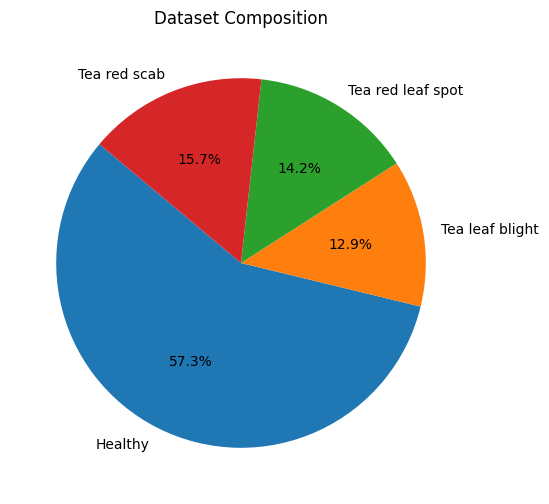

Dataset Composition (Absolute Counts):
Healthy: 2270
Tea leaf blight: 509
Tea red leaf spot: 561
Tea red scab: 620

Epoch 1/10


Train Loss: 0.7240, Train Acc: 0.7500
Val Loss: 0.3270, Val Acc: 0.9078

Epoch 2/10


Train Loss: 0.2746, Train Acc: 0.9113
Val Loss: 0.1579, Val Acc: 0.9508

Epoch 3/10


Train Loss: 0.1357, Train Acc: 0.9577
Val Loss: 0.1673, Val Acc: 0.9432

Epoch 4/10


Train Loss: 0.1047, Train Acc: 0.9672
Val Loss: 0.0673, Val Acc: 0.9798

Epoch 5/10


Train Loss: 0.0691, Train Acc: 0.9798
Val Loss: 0.0723, Val Acc: 0.9785

Epoch 6/10


Train Loss: 0.0731, Train Acc: 0.9760
Val Loss: 0.0733, Val Acc: 0.9773

Epoch 7/10


Train Loss: 0.0562, Train Acc: 0.9833
Val Loss: 0.0366, Val Acc: 0.9912

Epoch 8/10


Train Loss: 0.0660, Train Acc: 0.9817
Val Loss: 0.0464, Val Acc: 0.9861

Epoch 9/10


Train Loss: 0.0286, Train Acc: 0.9905
Val Loss: 0.0431, Val Acc: 0.9811

Epoch 10/10


Train Loss: 0.0397, Train Acc: 0.9893
Val Loss: 0.1322, Val Acc: 0.9684


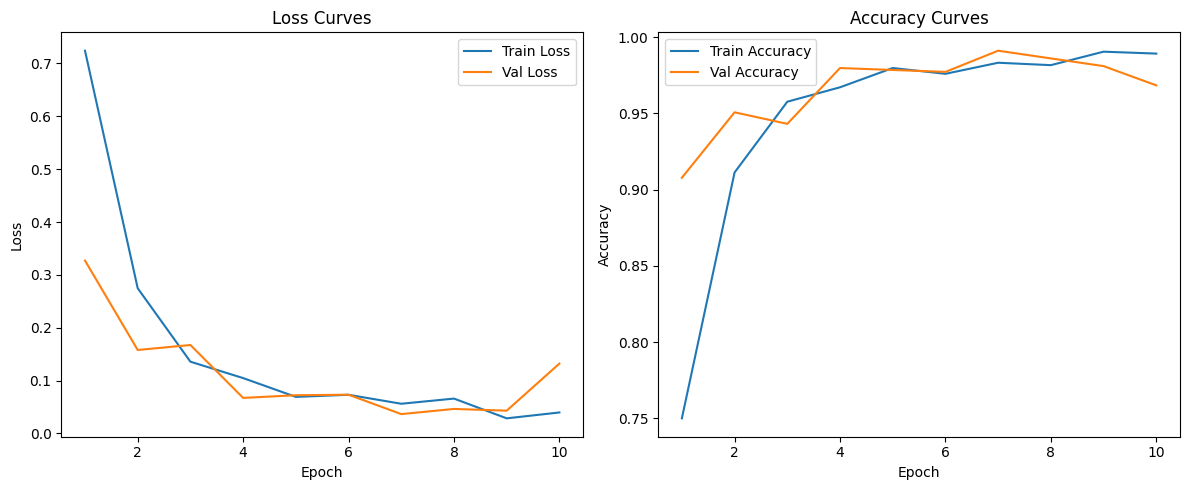


Final Test Loss: 0.1322, Test Accuracy: 0.9684


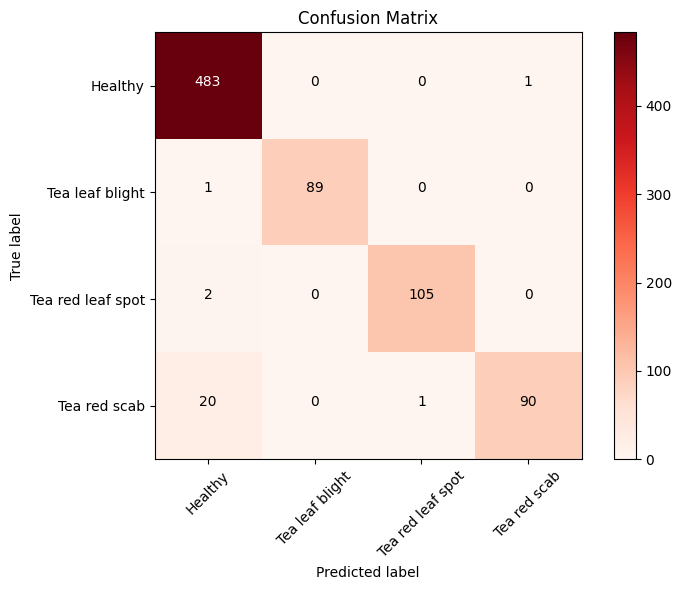

Classification Report:
                   precision    recall  f1-score     support
Healthy             0.954545  0.997934  0.975758  484.000000
Tea leaf blight     1.000000  0.988889  0.994413   90.000000
Tea red leaf spot   0.990566  0.981308  0.985915  107.000000
Tea red scab        0.989011  0.810811  0.891089  111.000000
accuracy            0.968434  0.968434  0.968434    0.968434
macro avg           0.983531  0.944735  0.961794  792.000000
weighted avg        0.969408  0.968434  0.967383  792.000000


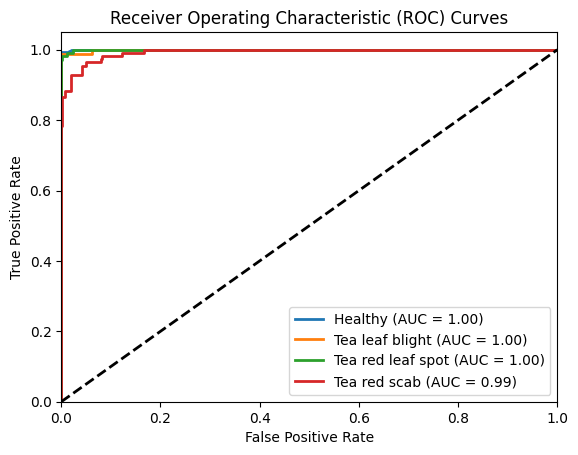

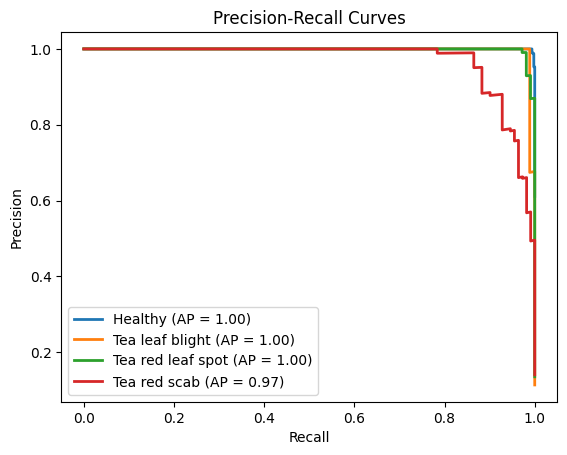

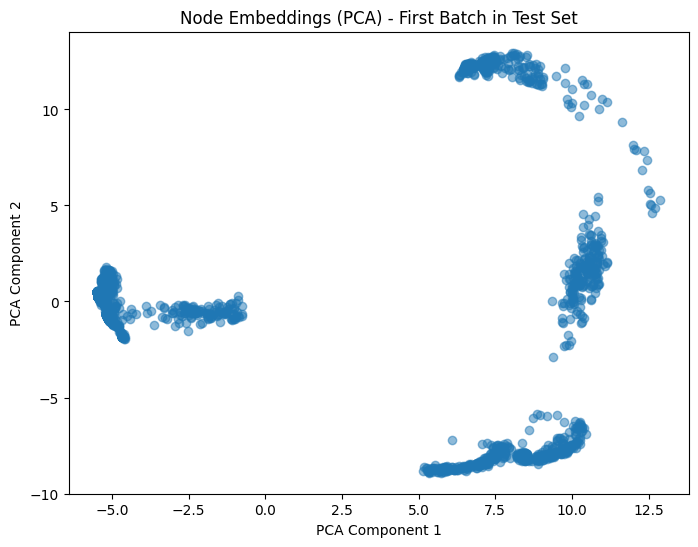

TypeError: Invalid shape (196,) for image data

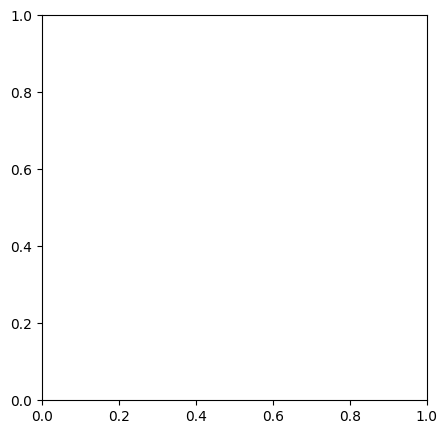

In [10]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
import itertools
import pandas as pd

# Optional: for network architecture visualization (requires torchviz)
try:
    from torchviz import make_dot
    TORCHVIZ_AVAILABLE = True
except ImportError:
    TORCHVIZ_AVAILABLE = False

# -------------------- Hyperparameters and Paths --------------------
data_dir = '/home/idrone2/Desktop/Kaggle_datasets/Tea_leaf_dataset'  # Adjust path as needed
batch_size = 16
num_epochs = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- Data Transforms --------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# -------------------- Load Full Dataset --------------------
full_dataset = datasets.ImageFolder(data_dir)  # No transform initially
num_classes = len(full_dataset.classes)  # Dynamically set num_classes
print(f"Number of classes in dataset: {num_classes}")
print(f"Class names: {full_dataset.classes}")

# -------------------- Pie Chart for Dataset Composition --------------------
class_names = full_dataset.classes
class_counts = [0] * num_classes
for _, label in full_dataset.samples:
    class_counts[label] += 1

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title("Dataset Composition")
plt.savefig('dataset_composition_pie.png')
plt.show()
plt.close()

print("Dataset Composition (Absolute Counts):")
for cls_name, count in zip(class_names, class_counts):
    print(f"{cls_name}: {count}")

# -------------------- Perform 76/24 Split --------------------
dataset_size = len(full_dataset)
train_size = int(0.80 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Set transforms for each subset
train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = val_test_transforms

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=min(batch_size, len(test_dataset)), shuffle=False, num_workers=4)

# -------------------- ViG-Inspired Model Definition --------------------
class ViGBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super(ViGBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
    
    def forward(self, x, return_attn=False):
        x = x.transpose(0, 1)  # [N, B, D] for attention
        attn_out, attn_weights = self.attn(x, x, x)
        x = x + attn_out
        x = self.norm1(x)
        fc_out = self.fc(x)
        x = x + fc_out
        x = self.norm2(x)
        if return_attn:
            return x.transpose(0, 1), attn_weights
        else:
            return x.transpose(0, 1)

class ViG(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=num_classes, embed_dim=128, depth=4, num_heads=4):
        super(ViG, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.blocks = nn.ModuleList([ViGBlock(dim=embed_dim, num_heads=num_heads) for _ in range(depth)])
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x, return_attention=False):
        x = self.patch_embed(x)  # [B, embed_dim, H', W']
        B, C, H, W = x.shape
        node_embeddings = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]

        attn_weights_all = []
        for idx, block in enumerate(self.blocks):
            if return_attention and idx == 0:
                node_embeddings, attn_weights = block(node_embeddings, return_attn=True)
                attn_weights_all.append(attn_weights)
            else:
                node_embeddings = block(node_embeddings)

        final_node_embeddings = node_embeddings
        x = node_embeddings.transpose(1, 2)  # [B, embed_dim, num_patches]
        x = self.global_pool(x).squeeze(-1)  # [B, embed_dim]
        x = self.fc(x)
        if return_attention:
            return x, final_node_embeddings, attn_weights_all[0]
        else:
            return x

model = ViG(num_classes=num_classes).to(device)

# -------------------- Training and Evaluation Functions --------------------
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
    return running_loss / total, correct / total

def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    all_probs = np.concatenate(all_probs, axis=0) if len(all_probs) > 0 else np.array([])
    return running_loss / total, correct / total, all_preds, all_labels, all_probs

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------- Training Loop --------------------
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = eval_model(model, test_loader, criterion)
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# -------------------- Accuracy and Loss Plots --------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()
plt.close()

# -------------------- Evaluate on Test Set --------------------
test_loss, test_acc, all_preds, all_labels, all_probs = eval_model(model, test_loader, criterion)
print(f"\nFinal Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# -------------------- Confusion Matrix --------------------
cm = confusion_matrix(all_labels, all_preds)
classes = full_dataset.classes
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
plt.close()

# -------------------- Classification Report --------------------
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("Classification Report:")
print(df_report)
df_report.to_csv('classification_report.csv', index=True)

# -------------------- ROC Curves --------------------
if len(all_probs) > 0:
    binarized_labels = label_binarize(all_labels, classes=range(num_classes))
    fpr = {}
    tpr = {}
    roc_auc = {}
    plt.figure()
    for i in range(num_classes):
        if np.sum(binarized_labels[:, i]) == 0:
            print(f"No samples with label '{classes[i]}' in the test set. Skipping ROC.")
            continue
        fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{classes[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png')
    plt.show()
    plt.close()
else:
    print("No probability data available for ROC curves.")

# -------------------- Precision-Recall (PR) Curves --------------------
if len(all_probs) > 0:
    plt.figure()
    for i in range(num_classes):
        if np.sum(binarized_labels[:, i]) == 0:
            print(f"No samples with label '{classes[i]}' in the test set. Skipping PR curve.")
            continue
        precision, recall, _ = precision_recall_curve(binarized_labels[:, i], all_probs[:, i])
        ap = average_precision_score(binarized_labels[:, i], all_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f'{classes[i]} (AP = {ap:0.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="lower left")
    plt.savefig('pr_curves.png')
    plt.show()
    plt.close()
else:
    print("No probability data available for PR curves.")

# -------------------- Node Embeddings Visualization (PCA) --------------------
def get_node_embeddings(model, loader):
    model.eval()
    try:
        with torch.no_grad():
            images, _ = next(iter(loader))
            images = images.to(device)
            _, node_embeddings, _ = model(images, return_attention=True)
            return node_embeddings.cpu().numpy()
    except StopIteration:
        print("Test loader is empty. Cannot compute node embeddings.")
        return None

node_embeddings = get_node_embeddings(model, test_loader)
if node_embeddings is not None:
    B, N, D = node_embeddings.shape
    node_embeddings_flat = node_embeddings.reshape(-1, D)
    pca = PCA(n_components=2)
    node_embeddings_2d = pca.fit_transform(node_embeddings_flat)
    plt.figure(figsize=(8, 6))
    plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], alpha=0.5)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Node Embeddings (PCA) - First Batch in Test Set")
    plt.savefig("node_embeddings.png")
    plt.show()
    plt.close()

# -------------------- Graph Attention Weights Visualization --------------------
def get_attention_weights(model, loader):
    model.eval()
    try:
        with torch.no_grad():
            images, _ = next(iter(loader))
            images = images.to(device)
            _, _, attn_weights = model(images, return_attention=True)
            return attn_weights.cpu().numpy()
    except StopIteration:
        print("Test loader is empty. Cannot compute attention weights.")
        return None

attn_weights = get_attention_weights(model, test_loader)
if attn_weights is not None:
    sample_attn = attn_weights[0, 0]  # shape: [N, N]
    plt.figure(figsize=(6, 5))
    plt.imshow(sample_attn, cmap='viridis')
    plt.title("Graph Attention Weights (Head=1, Sample=1)")
    plt.colorbar()
    plt.savefig("graph_attention_weights.png")
    plt.show()
    plt.close()

# -------------------- Graph Convolutional Layer (Patch Embedding) Weights Distribution --------------------
patch_weights = model.patch_embed.weight.data.cpu().numpy()
plt.figure(figsize=(8, 6))
plt.hist(patch_weights.flatten(), bins=50, color='gray')
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Patch Embedding Weights Distribution")
plt.savefig("graph_conv_weights.png")
plt.show()
plt.close()

# -------------------- Architecture Summary --------------------
print("\nModel Architecture Summary:")
print(model)

if TORCHVIZ_AVAILABLE:
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    dot = make_dot(model(sample_input), params=dict(model.named_parameters()))
    dot.format = 'png'
    dot.render("model_architecture_graph")
    print("Model architecture graph saved as 'model_architecture_graph.png'.")
else:
    print("torchviz not available. Install it via 'pip install torchviz' to visualize the model architecture.")

# -------------------- Save Final Model Weights --------------------
torch.save(model.state_dict(), 'vig_model_final.pth')
print("\nTraining and analysis complete. Model saved as 'vig_model_final.pth'.")

Number of classes in dataset: 4
Class names: ['Healthy', 'Tea leaf blight', 'Tea red leaf spot', 'Tea red scab']


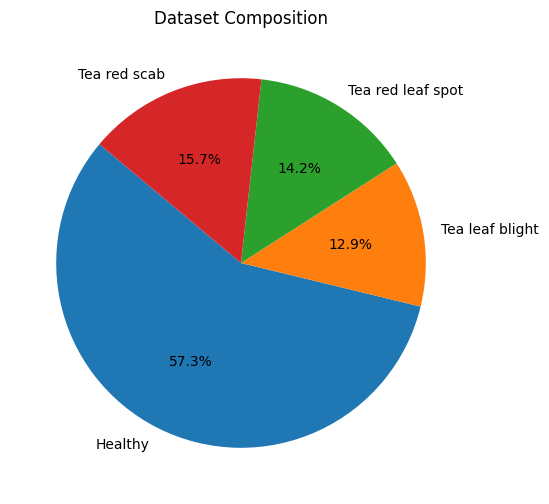

Dataset Composition (Absolute Counts):
Healthy: 2270
Tea leaf blight: 509
Tea red leaf spot: 561
Tea red scab: 620

Epoch 1/10


Train Loss: 0.7913, Train Acc: 0.7198
Val Loss: 0.3708, Val Acc: 0.8959

Epoch 2/10


Train Loss: 0.3413, Train Acc: 0.8917
Val Loss: 0.2374, Val Acc: 0.9264

Epoch 3/10


Train Loss: 0.2173, Train Acc: 0.9335
Val Loss: 0.1368, Val Acc: 0.9485

Epoch 4/10


Train Loss: 0.1218, Train Acc: 0.9658
Val Loss: 0.0777, Val Acc: 0.9821

Epoch 5/10


Train Loss: 0.1213, Train Acc: 0.9634
Val Loss: 0.0612, Val Acc: 0.9811

Epoch 6/10


Train Loss: 0.0609, Train Acc: 0.9804
Val Loss: 0.0522, Val Acc: 0.9790

Epoch 7/10


Train Loss: 0.0518, Train Acc: 0.9870
Val Loss: 0.0460, Val Acc: 0.9832

Epoch 8/10


Train Loss: 0.0431, Train Acc: 0.9860
Val Loss: 0.0234, Val Acc: 0.9916

Epoch 9/10


Train Loss: 0.0353, Train Acc: 0.9904
Val Loss: 0.0224, Val Acc: 0.9937

Epoch 10/10


Train Loss: 0.0470, Train Acc: 0.9844
Val Loss: 0.0388, Val Acc: 0.9853


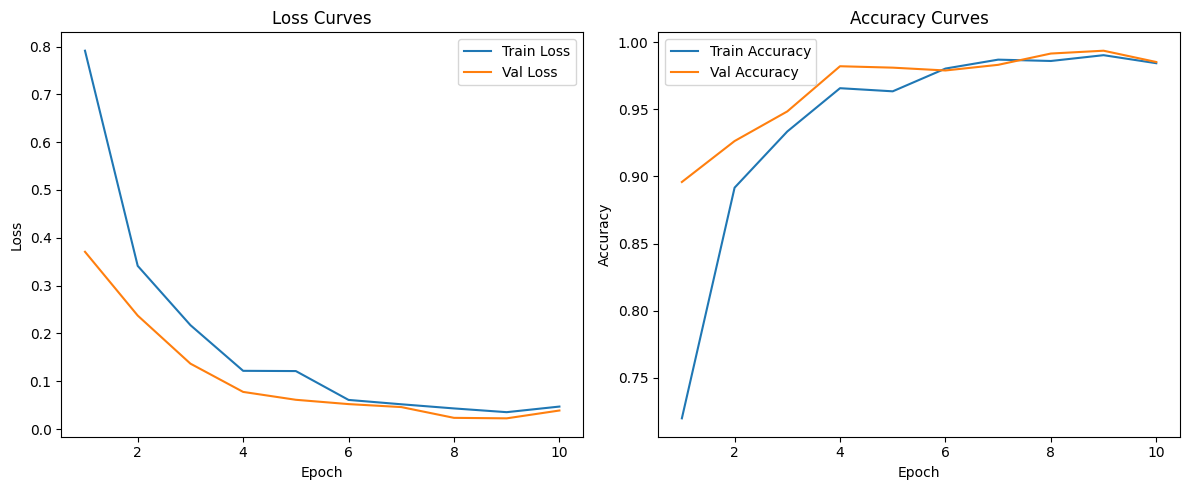


Final Test Loss: 0.0388, Test Accuracy: 0.9853


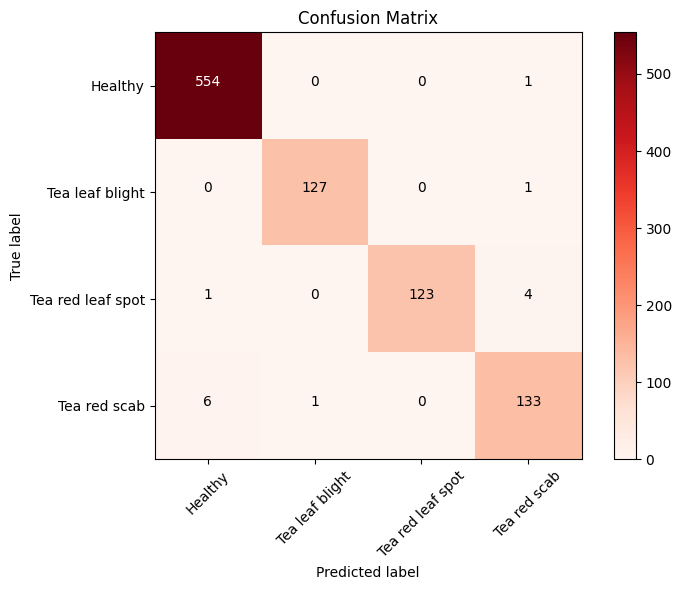

Classification Report:
                   precision    recall  f1-score     support
Healthy             0.987522  0.998198  0.992832  555.000000
Tea leaf blight     0.992188  0.992188  0.992188  128.000000
Tea red leaf spot   1.000000  0.960938  0.980080  128.000000
Tea red scab        0.956835  0.950000  0.953405  140.000000
accuracy            0.985279  0.985279  0.985279    0.985279
macro avg           0.984136  0.975331  0.979626  951.000000
weighted avg        0.985312  0.985279  0.985224  951.000000


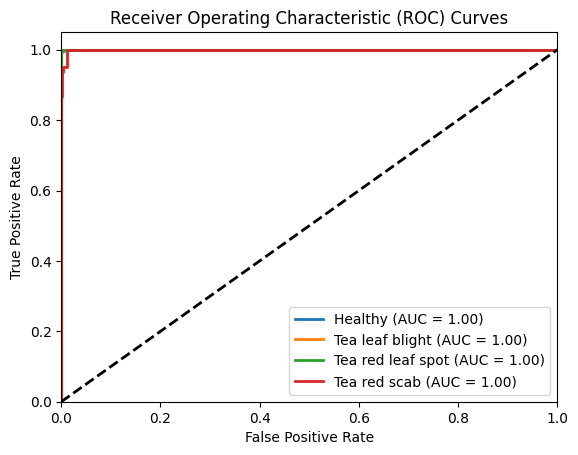

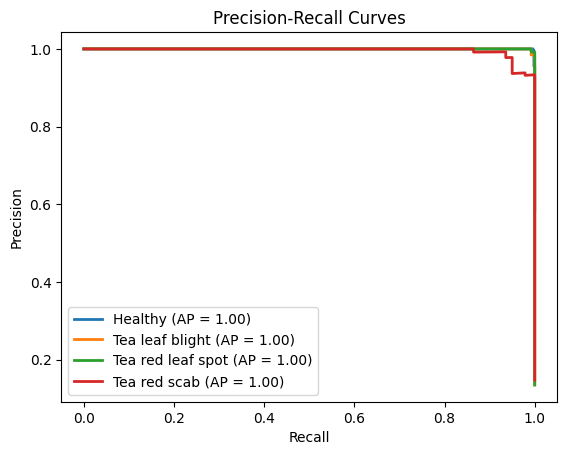

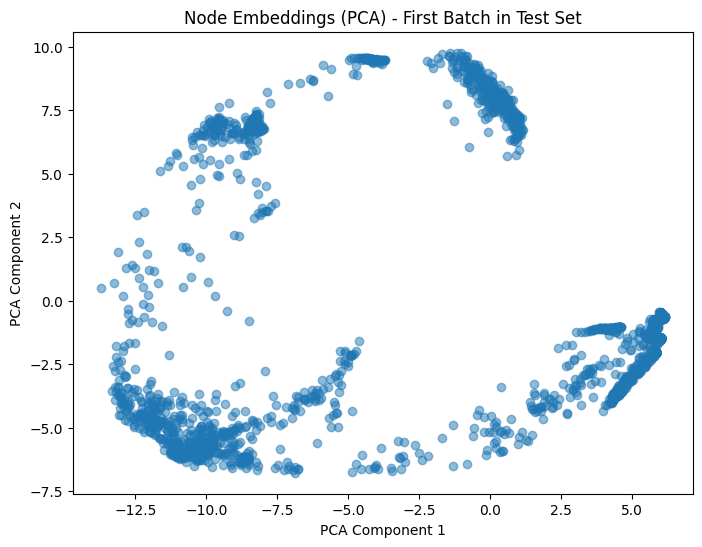

Attention weights shape: (16, 196, 196)
Unexpected attention shape: (196,). Expected 2D array.


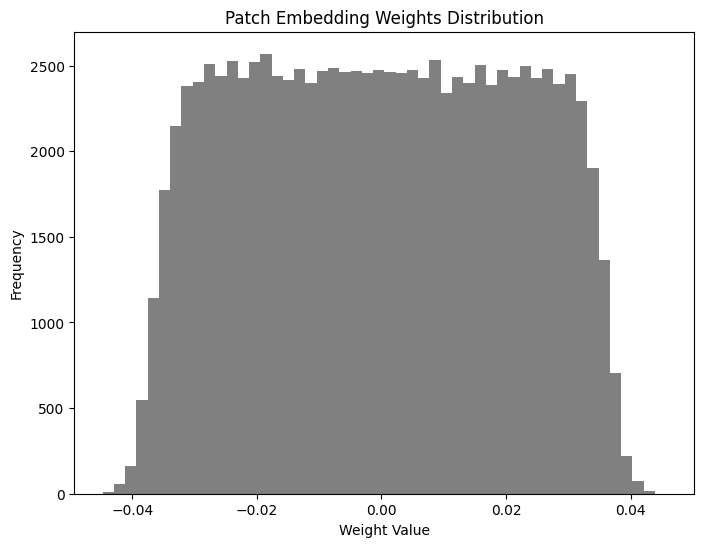


Model Architecture Summary:
ViG(
  (patch_embed): Conv2d(3, 128, kernel_size=(16, 16), stride=(16, 16))
  (blocks): ModuleList(
    (0-3): 4 x ViGBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)
torchviz not available. Install it via 'pip install torchviz' to visualize the model architecture.

Training and analysis complete. Model saved as 'vig_model_final.pth'.


In [11]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
import itertools
import pandas as pd

# Optional: for network architecture visualization (requires torchviz)
try:
    from torchviz import make_dot
    TORCHVIZ_AVAILABLE = True
except ImportError:
    TORCHVIZ_AVAILABLE = False

# -------------------- Hyperparameters and Paths --------------------
data_dir = '/home/idrone2/Desktop/Kaggle_datasets/Tea_leaf_dataset'  # Adjust path as needed
batch_size = 16
num_epochs = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- Data Transforms --------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# -------------------- Load Full Dataset --------------------
full_dataset = datasets.ImageFolder(data_dir)  # No transform initially
num_classes = len(full_dataset.classes)  # Dynamically set num_classes
print(f"Number of classes in dataset: {num_classes}")
print(f"Class names: {full_dataset.classes}")

# -------------------- Pie Chart for Dataset Composition --------------------
class_names = full_dataset.classes
class_counts = [0] * num_classes
for _, label in full_dataset.samples:
    class_counts[label] += 1

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title("Dataset Composition")
plt.savefig('dataset_composition_pie.png')
plt.show()
plt.close()

print("Dataset Composition (Absolute Counts):")
for cls_name, count in zip(class_names, class_counts):
    print(f"{cls_name}: {count}")

# -------------------- Perform 76/24 Split --------------------
dataset_size = len(full_dataset)
train_size = int(0.76 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Set transforms for each subset
train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = val_test_transforms

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=min(batch_size, len(test_dataset)), shuffle=False, num_workers=4)

# -------------------- ViG-Inspired Model Definition --------------------
class ViGBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super(ViGBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
    
    def forward(self, x, return_attn=False):
        x = x.transpose(0, 1)  # [N, B, D] for attention
        attn_out, attn_weights = self.attn(x, x, x)
        x = x + attn_out
        x = self.norm1(x)
        fc_out = self.fc(x)
        x = x + fc_out
        x = self.norm2(x)
        if return_attn:
            return x.transpose(0, 1), attn_weights
        else:
            return x.transpose(0, 1)

class ViG(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=num_classes, embed_dim=128, depth=4, num_heads=4):
        super(ViG, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.blocks = nn.ModuleList([ViGBlock(dim=embed_dim, num_heads=num_heads) for _ in range(depth)])
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x, return_attention=False):
        x = self.patch_embed(x)  # [B, embed_dim, H', W']
        B, C, H, W = x.shape
        node_embeddings = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]

        attn_weights_all = []
        for idx, block in enumerate(self.blocks):
            if return_attention and idx == 0:
                node_embeddings, attn_weights = block(node_embeddings, return_attn=True)
                attn_weights_all.append(attn_weights)
            else:
                node_embeddings = block(node_embeddings)

        final_node_embeddings = node_embeddings
        x = node_embeddings.transpose(1, 2)  # [B, embed_dim, num_patches]
        x = self.global_pool(x).squeeze(-1)  # [B, embed_dim]
        x = self.fc(x)
        if return_attention:
            return x, final_node_embeddings, attn_weights_all[0]
        else:
            return x

model = ViG(num_classes=num_classes).to(device)

# -------------------- Training and Evaluation Functions --------------------
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
    return running_loss / total, correct / total

def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    all_probs = np.concatenate(all_probs, axis=0) if len(all_probs) > 0 else np.array([])
    return running_loss / total, correct / total, all_preds, all_labels, all_probs

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------- Training Loop --------------------
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = eval_model(model, test_loader, criterion)
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# -------------------- Accuracy and Loss Plots --------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()
plt.close()

# -------------------- Evaluate on Test Set --------------------
test_loss, test_acc, all_preds, all_labels, all_probs = eval_model(model, test_loader, criterion)
print(f"\nFinal Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# -------------------- Confusion Matrix --------------------
cm = confusion_matrix(all_labels, all_preds)
classes = full_dataset.classes
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
plt.close()

# -------------------- Classification Report --------------------
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("Classification Report:")
print(df_report)
df_report.to_csv('classification_report.csv', index=True)

# -------------------- ROC Curves --------------------
if len(all_probs) > 0:
    binarized_labels = label_binarize(all_labels, classes=range(num_classes))
    fpr = {}
    tpr = {}
    roc_auc = {}
    plt.figure()
    for i in range(num_classes):
        if np.sum(binarized_labels[:, i]) == 0:
            print(f"No samples with label '{classes[i]}' in the test set. Skipping ROC.")
            continue
        fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{classes[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png')
    plt.show()
    plt.close()
else:
    print("No probability data available for ROC curves.")

# -------------------- Precision-Recall (PR) Curves --------------------
if len(all_probs) > 0:
    plt.figure()
    for i in range(num_classes):
        if np.sum(binarized_labels[:, i]) == 0:
            print(f"No samples with label '{classes[i]}' in the test set. Skipping PR curve.")
            continue
        precision, recall, _ = precision_recall_curve(binarized_labels[:, i], all_probs[:, i])
        ap = average_precision_score(binarized_labels[:, i], all_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f'{classes[i]} (AP = {ap:0.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="lower left")
    plt.savefig('pr_curves.png')
    plt.show()
    plt.close()
else:
    print("No probability data available for PR curves.")

# -------------------- Node Embeddings Visualization (PCA) --------------------
def get_node_embeddings(model, loader):
    model.eval()
    try:
        with torch.no_grad():
            images, _ = next(iter(loader))
            images = images.to(device)
            _, node_embeddings, _ = model(images, return_attention=True)
            return node_embeddings.cpu().numpy()
    except StopIteration:
        print("Test loader is empty. Cannot compute node embeddings.")
        return None

node_embeddings = get_node_embeddings(model, test_loader)
if node_embeddings is not None:
    B, N, D = node_embeddings.shape
    node_embeddings_flat = node_embeddings.reshape(-1, D)
    pca = PCA(n_components=2)
    node_embeddings_2d = pca.fit_transform(node_embeddings_flat)
    plt.figure(figsize=(8, 6))
    plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], alpha=0.5)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Node Embeddings (PCA) - First Batch in Test Set")
    plt.savefig("node_embeddings.png")
    plt.show()
    plt.close()

# -------------------- Graph Attention Weights Visualization --------------------
def get_attention_weights(model, loader):
    model.eval()
    try:
        with torch.no_grad():
            images, _ = next(iter(loader))
            images = images.to(device)
            _, _, attn_weights = model(images, return_attention=True)
            return attn_weights.cpu().numpy()
    except StopIteration:
        print("Test loader is empty. Cannot compute attention weights.")
        return None

attn_weights = get_attention_weights(model, test_loader)
if attn_weights is not None:
    print(f"Attention weights shape: {attn_weights.shape}")  # Debug shape
    sample_attn = attn_weights[0, 0]  # shape: [N, N], e.g., [196, 196]
    if sample_attn.ndim != 2:
        print(f"Unexpected attention shape: {sample_attn.shape}. Expected 2D array.")
    else:
        plt.figure(figsize=(6, 5))
        plt.imshow(sample_attn, cmap='viridis')
        plt.title("Graph Attention Weights (Head=1, Sample=1)")
        plt.colorbar()
        plt.savefig("graph_attention_weights.png")
        plt.show()
        plt.close()
else:
    print("No attention weights available for visualization.")

# -------------------- Graph Convolutional Layer (Patch Embedding) Weights Distribution --------------------
patch_weights = model.patch_embed.weight.data.cpu().numpy()
plt.figure(figsize=(8, 6))
plt.hist(patch_weights.flatten(), bins=50, color='gray')
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Patch Embedding Weights Distribution")
plt.savefig("graph_conv_weights.png")
plt.show()
plt.close()

# -------------------- Architecture Summary --------------------
print("\nModel Architecture Summary:")
print(model)

if TORCHVIZ_AVAILABLE:
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    dot = make_dot(model(sample_input), params=dict(model.named_parameters()))
    dot.format = 'png'
    dot.render("model_architecture_graph")
    print("Model architecture graph saved as 'model_architecture_graph.png'.")
else:
    print("torchviz not available. Install it via 'pip install torchviz' to visualize the model architecture.")

# -------------------- Save Final Model Weights --------------------
torch.save(model.state_dict(), 'vig_model_final.pth')
print("\nTraining and analysis complete. Model saved as 'vig_model_final.pth'.")

Number of classes in dataset: 4
Class names: ['Healthy', 'Tea leaf blight', 'Tea red leaf spot', 'Tea red scab']


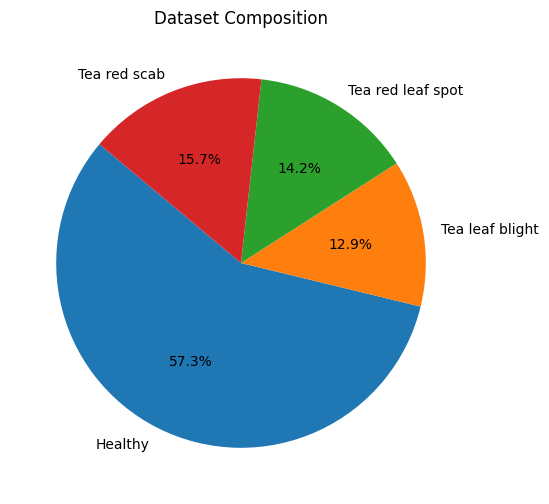

Dataset Composition (Absolute Counts):
Healthy: 2270
Tea leaf blight: 509
Tea red leaf spot: 561
Tea red scab: 620

Model Parameter List:
Layer Name                                         Shape                Number of Parameters
------------------------------------------------------------------------------------------
patch_embed.weight                                 [128, 3, 16, 16]     98304               
patch_embed.bias                                   [128]                128                 
blocks.0.attn.in_proj_weight                       [384, 128]           49152               
blocks.0.attn.in_proj_bias                         [384]                384                 
blocks.0.attn.out_proj.weight                      [128, 128]           16384               
blocks.0.attn.out_proj.bias                        [128]                128                 
blocks.0.fc.0.weight                               [512, 128]           65536               
blocks.0.fc.0.bias         

Train Loss: 0.7046, Train Acc: 0.7468
Val Loss: 0.3180, Val Acc: 0.8896

Epoch 2/10


Train Loss: 0.2383, Train Acc: 0.9305
Val Loss: 0.1222, Val Acc: 0.9621

Epoch 3/10


Train Loss: 0.1042, Train Acc: 0.9694
Val Loss: 0.0599, Val Acc: 0.9842

Epoch 4/10


Train Loss: 0.0771, Train Acc: 0.9784
Val Loss: 0.0415, Val Acc: 0.9905

Epoch 5/10


Train Loss: 0.0542, Train Acc: 0.9827
Val Loss: 0.0357, Val Acc: 0.9895

Epoch 6/10


Train Loss: 0.0478, Train Acc: 0.9860
Val Loss: 0.0237, Val Acc: 0.9937

Epoch 7/10


Train Loss: 0.0257, Train Acc: 0.9924
Val Loss: 0.0343, Val Acc: 0.9884

Epoch 8/10


Train Loss: 0.0346, Train Acc: 0.9874
Val Loss: 0.0275, Val Acc: 0.9926

Epoch 9/10


Train Loss: 0.0295, Train Acc: 0.9907
Val Loss: 0.0175, Val Acc: 0.9947

Epoch 10/10


Train Loss: 0.0294, Train Acc: 0.9900
Val Loss: 0.0508, Val Acc: 0.9863


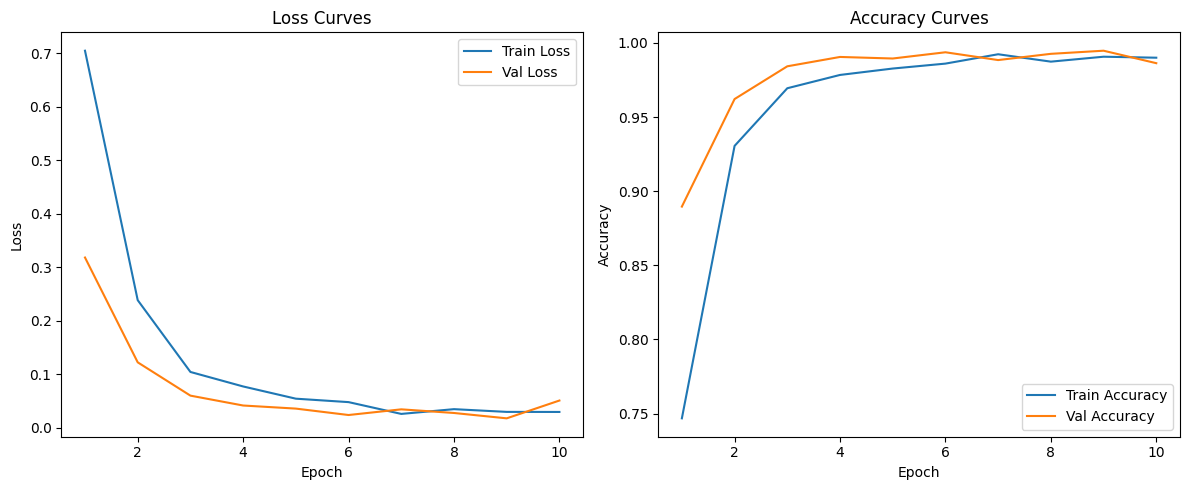


Final Test Loss: 0.0508, Test Accuracy: 0.9863


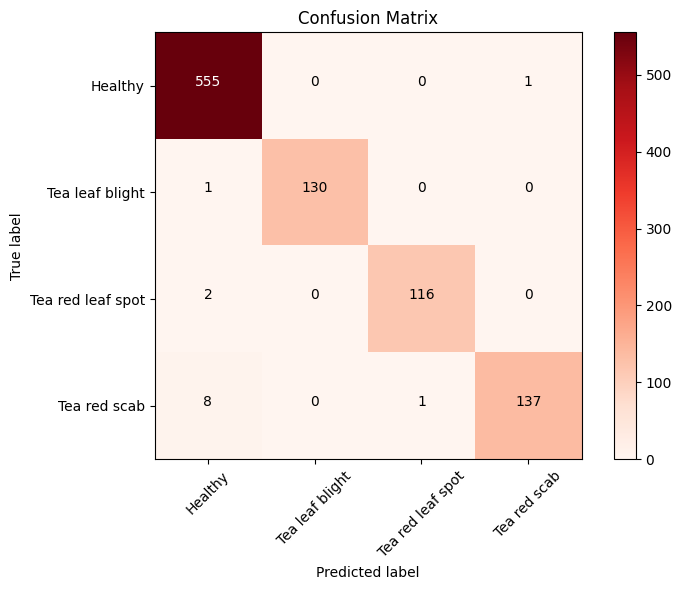

Classification Report:
                   precision    recall  f1-score    support
Healthy             0.980565  0.998201  0.989305  556.00000
Tea leaf blight     1.000000  0.992366  0.996169  131.00000
Tea red leaf spot   0.991453  0.983051  0.987234  118.00000
Tea red scab        0.992754  0.938356  0.964789  146.00000
accuracy            0.986330  0.986330  0.986330    0.98633
macro avg           0.991193  0.977994  0.984374  951.00000
weighted avg        0.986465  0.986330  0.986230  951.00000


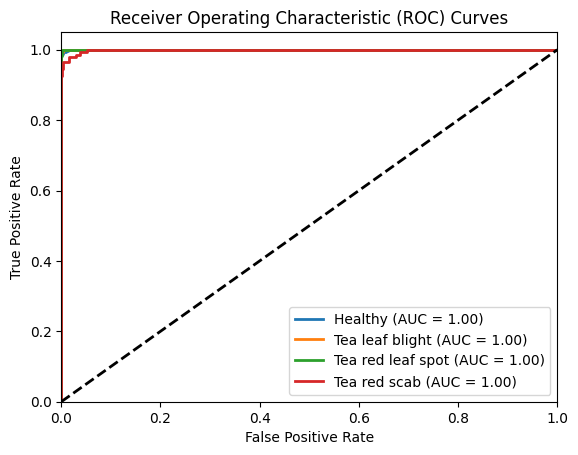

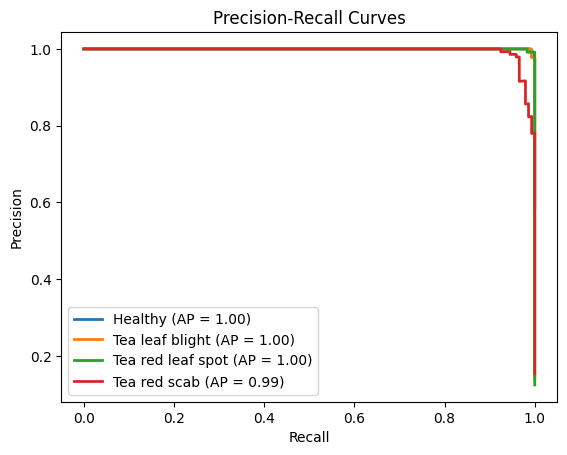

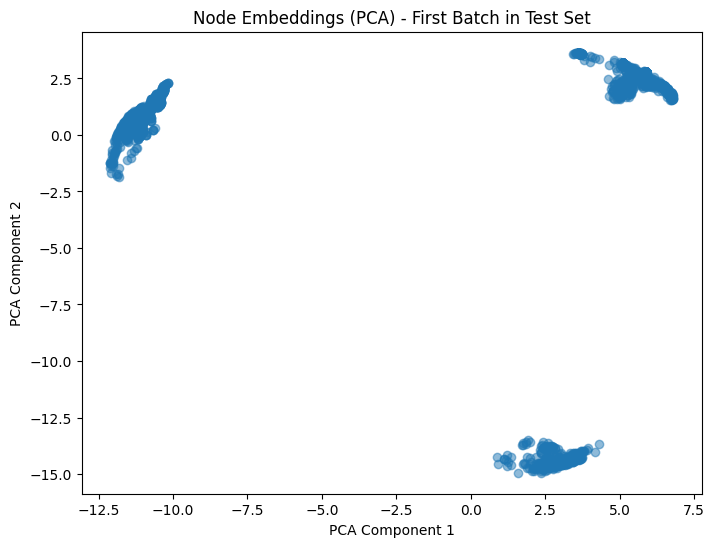

Attention weights shape: (16, 196, 196)
Unexpected attention shape: (196,). Expected 2D array.


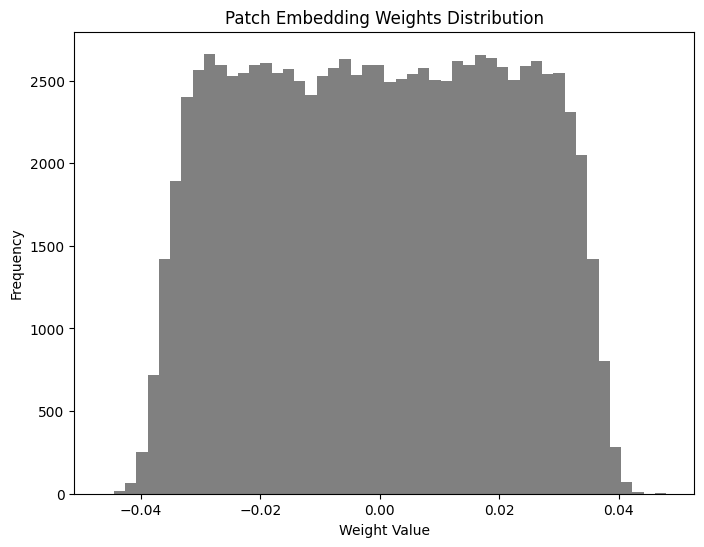


Model Architecture Summary:
ViG(
  (patch_embed): Conv2d(3, 128, kernel_size=(16, 16), stride=(16, 16))
  (blocks): ModuleList(
    (0-3): 4 x ViGBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)
torchviz not available. Install it via 'pip install torchviz' to visualize the model architecture.

Training and analysis complete. Model saved as 'vig_model_final.pth'.


In [12]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
import itertools
import pandas as pd

# Optional: for network architecture visualization (requires torchviz)
try:
    from torchviz import make_dot
    TORCHVIZ_AVAILABLE = True
except ImportError:
    TORCHVIZ_AVAILABLE = False

# -------------------- Hyperparameters and Paths --------------------
data_dir = '/home/idrone2/Desktop/Kaggle_datasets/Tea_leaf_dataset'  # Adjust path as needed
batch_size = 16
num_epochs = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- Data Transforms --------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# -------------------- Load Full Dataset --------------------
full_dataset = datasets.ImageFolder(data_dir)  # No transform initially
num_classes = len(full_dataset.classes)  # Dynamically set num_classes
print(f"Number of classes in dataset: {num_classes}")
print(f"Class names: {full_dataset.classes}")

# -------------------- Pie Chart for Dataset Composition --------------------
class_names = full_dataset.classes
class_counts = [0] * num_classes
for _, label in full_dataset.samples:
    class_counts[label] += 1

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title("Dataset Composition")
plt.savefig('dataset_composition_pie.png')
plt.show()
plt.close()

print("Dataset Composition (Absolute Counts):")
for cls_name, count in zip(class_names, class_counts):
    print(f"{cls_name}: {count}")

# -------------------- Perform 76/24 Split --------------------
dataset_size = len(full_dataset)
train_size = int(0.76 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Set transforms for each subset
train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = val_test_transforms

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=min(batch_size, len(test_dataset)), shuffle=False, num_workers=4)

# -------------------- ViG-Inspired Model Definition --------------------
class ViGBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super(ViGBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
    
    def forward(self, x, return_attn=False):
        x = x.transpose(0, 1)  # [N, B, D] for attention
        attn_out, attn_weights = self.attn(x, x, x)
        x = x + attn_out
        x = self.norm1(x)
        fc_out = self.fc(x)
        x = x + fc_out
        x = self.norm2(x)
        if return_attn:
            return x.transpose(0, 1), attn_weights
        else:
            return x.transpose(0, 1)

class ViG(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=num_classes, embed_dim=128, depth=4, num_heads=4):
        super(ViG, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.blocks = nn.ModuleList([ViGBlock(dim=embed_dim, num_heads=num_heads) for _ in range(depth)])
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x, return_attention=False):
        x = self.patch_embed(x)  # [B, embed_dim, H', W']
        B, C, H, W = x.shape
        node_embeddings = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]

        attn_weights_all = []
        for idx, block in enumerate(self.blocks):
            if return_attention and idx == 0:
                node_embeddings, attn_weights = block(node_embeddings, return_attn=True)
                attn_weights_all.append(attn_weights)
            else:
                node_embeddings = block(node_embeddings)

        final_node_embeddings = node_embeddings
        x = node_embeddings.transpose(1, 2)  # [B, embed_dim, num_patches]
        x = self.global_pool(x).squeeze(-1)  # [B, embed_dim]
        x = self.fc(x)
        if return_attention:
            return x, final_node_embeddings, attn_weights_all[0]
        else:
            return x

model = ViG(num_classes=num_classes).to(device)

# -------------------- Export Model Parameters --------------------
def export_model_parameters(model, csv_filename='model_parameters.csv'):
    params_list = []
    total_params = 0
    print("\nModel Parameter List:")
    print(f"{'Layer Name':<50} {'Shape':<20} {'Number of Parameters':<20}")
    print("-" * 90)
    for name, param in model.named_parameters():
        num_params = param.numel()
        total_params += num_params
        params_list.append({
            'layer': name,
            'shape': list(param.shape),
            'num_params': num_params
        })
        print(f"{name:<50} {str(list(param.shape)):<20} {num_params:<20}")
    
    print("-" * 90)
    print(f"Total number of parameters: {total_params}")

    # Export to CSV
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = ['layer', 'shape', 'num_params']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(params_list)
    print(f"Parameters exported to '{csv_filename}'")

# Export parameters before training
export_model_parameters(model)

# -------------------- Training and Evaluation Functions --------------------
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
    return running_loss / total, correct / total

def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    all_probs = np.concatenate(all_probs, axis=0) if len(all_probs) > 0 else np.array([])
    return running_loss / total, correct / total, all_preds, all_labels, all_probs

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------- Training Loop --------------------
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = eval_model(model, test_loader, criterion)
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# -------------------- Accuracy and Loss Plots --------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()
plt.close()

# -------------------- Evaluate on Test Set --------------------
test_loss, test_acc, all_preds, all_labels, all_probs = eval_model(model, test_loader, criterion)
print(f"\nFinal Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# -------------------- Confusion Matrix --------------------
cm = confusion_matrix(all_labels, all_preds)
classes = full_dataset.classes
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
plt.close()

# -------------------- Classification Report --------------------
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("Classification Report:")
print(df_report)
df_report.to_csv('classification_report.csv', index=True)

# -------------------- ROC Curves --------------------
if len(all_probs) > 0:
    binarized_labels = label_binarize(all_labels, classes=range(num_classes))
    fpr = {}
    tpr = {}
    roc_auc = {}
    plt.figure()
    for i in range(num_classes):
        if np.sum(binarized_labels[:, i]) == 0:
            print(f"No samples with label '{classes[i]}' in the test set. Skipping ROC.")
            continue
        fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{classes[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png')
    plt.show()
    plt.close()
else:
    print("No probability data available for ROC curves.")

# -------------------- Precision-Recall (PR) Curves --------------------
if len(all_probs) > 0:
    plt.figure()
    for i in range(num_classes):
        if np.sum(binarized_labels[:, i]) == 0:
            print(f"No samples with label '{classes[i]}' in the test set. Skipping PR curve.")
            continue
        precision, recall, _ = precision_recall_curve(binarized_labels[:, i], all_probs[:, i])
        ap = average_precision_score(binarized_labels[:, i], all_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f'{classes[i]} (AP = {ap:0.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="lower left")
    plt.savefig('pr_curves.png')
    plt.show()
    plt.close()
else:
    print("No probability data available for PR curves.")

# -------------------- Node Embeddings Visualization (PCA) --------------------
def get_node_embeddings(model, loader):
    model.eval()
    try:
        with torch.no_grad():
            images, _ = next(iter(loader))
            images = images.to(device)
            _, node_embeddings, _ = model(images, return_attention=True)
            return node_embeddings.cpu().numpy()
    except StopIteration:
        print("Test loader is empty. Cannot compute node embeddings.")
        return None

node_embeddings = get_node_embeddings(model, test_loader)
if node_embeddings is not None:
    B, N, D = node_embeddings.shape
    node_embeddings_flat = node_embeddings.reshape(-1, D)
    pca = PCA(n_components=2)
    node_embeddings_2d = pca.fit_transform(node_embeddings_flat)
    plt.figure(figsize=(8, 6))
    plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], alpha=0.5)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Node Embeddings (PCA) - First Batch in Test Set")
    plt.savefig("node_embeddings.png")
    plt.show()
    plt.close()

# -------------------- Graph Attention Weights Visualization --------------------
def get_attention_weights(model, loader):
    model.eval()
    try:
        with torch.no_grad():
            images, _ = next(iter(loader))
            images = images.to(device)
            _, _, attn_weights = model(images, return_attention=True)
            return attn_weights.cpu().numpy()
    except StopIteration:
        print("Test loader is empty. Cannot compute attention weights.")
        return None

attn_weights = get_attention_weights(model, test_loader)
if attn_weights is not None:
    print(f"Attention weights shape: {attn_weights.shape}")  # Debug shape
    sample_attn = attn_weights[0, 0]  # shape: [N, N], e.g., [196, 196]
    if sample_attn.ndim != 2:
        print(f"Unexpected attention shape: {sample_attn.shape}. Expected 2D array.")
    else:
        plt.figure(figsize=(6, 5))
        plt.imshow(sample_attn, cmap='viridis')
        plt.title("Graph Attention Weights (Head=1, Sample=1)")
        plt.colorbar()
        plt.savefig("graph_attention_weights.png")
        plt.show()
        plt.close()
else:
    print("No attention weights available for visualization.")

# -------------------- Graph Convolutional Layer (Patch Embedding) Weights Distribution --------------------
patch_weights = model.patch_embed.weight.data.cpu().numpy()
plt.figure(figsize=(8, 6))
plt.hist(patch_weights.flatten(), bins=50, color='gray')
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Patch Embedding Weights Distribution")
plt.savefig("graph_conv_weights.png")
plt.show()
plt.close()

# -------------------- Architecture Summary --------------------
print("\nModel Architecture Summary:")
print(model)

if TORCHVIZ_AVAILABLE:
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    dot = make_dot(model(sample_input), params=dict(model.named_parameters()))
    dot.format = 'png'
    dot.render("model_architecture_graph")
    print("Model architecture graph saved as 'model_architecture_graph.png'.")
else:
    print("torchviz not available. Install it via 'pip install torchviz' to visualize the model architecture.")

# -------------------- Save Final Model Weights --------------------
torch.save(model.state_dict(), 'vig_model_final.pth')
print("\nTraining and analysis complete. Model saved as 'vig_model_final.pth'.")